In [1]:
from SimPEG import data, directives, maps, inverse_problem, optimization, data_misfit, inversion, utils, regularization
import SimPEG.potential_fields as PF
from SimPEG.utils import speye, kron3, sdiag, mkvc
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.spatial import cKDTree
from matplotlib.patches import Rectangle
# from GeoToolkit.Mag import Mag, Simulator
from discretize.utils import meshutils
import scipy.sparse as sp                   
import shutil


%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plotVectorsOctree(mesh, m, coord, axs=None, scale=1, lims=100, vec='w', resolution=10, normal='Z', actvMap=None, zorder=1):
    
    nC = int(m.shape[0]/3)
    m = m.reshape((nC, 3), order='F')
    
    normalInd = {'X': 0, 'Y': 1, 'Z': 2}[normal]
    antiNormalInd = {'X': [1, 2], 'Y': [0, 2], 'Z': [0, 1]}[normal]

#     xLim = (mesh.gridCC[:, antiNormalInd[0]].min(), mesh.gridCC[:, antiNormalInd[0]].max())
#     yLim = (mesh.gridCC[:, antiNormalInd[1]].min(), mesh.gridCC[:, antiNormalInd[1]].max())
    xLim = [-lims, lims]
    yLim = [-lims, lims]

    X,Y = np.meshgrid(np.arange(xLim[0], xLim[1], resolution), np.arange(yLim[0], yLim[1], resolution))
    Z = np.ones_like(X) * coord
    
    grid = np.zeros((np.ravel(X).shape[0], 3))

    grid[:, normalInd] = np.ravel(Z)
    grid[:, antiNormalInd] = np.c_[np.ravel(X), np.ravel(Y)]
    ind = np.unique(mesh._get_containing_cell_indexes(grid))
    
    # Interpolate values to mesh.gridCC if not 'CC'
    if actvMap is not None:
        mx = (actvMap*m[:, 0])
        my = (actvMap*m[:, 1])
        mz = (actvMap*m[:, 2])

        m = np.c_[mx, my, mz]
      
    if axs is None:
        axs = plt.subplot()
        
#     print(grid)
    axs.quiver(mesh.gridCC[ind, antiNormalInd[0]],
               mesh.gridCC[ind, antiNormalInd[1]],
               m[ind, antiNormalInd[0]],
               m[ind, antiNormalInd[1]],
               pivot='mid',
               scale_units="inches", scale=scale, linewidths=(1,),
               edgecolors=(vec),
               headaxislength=0.1, headwidth=10, headlength=30, zorder=zorder)
    
    return axs
    

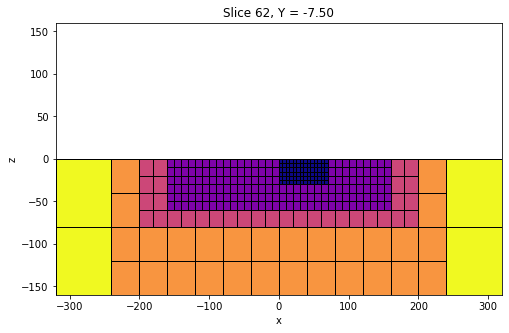

In [3]:
# # STEP 1: Setup and data simulation # #

# Magnetic inducing field parameter (A,I,D)
B = [50000, 90, 0]
midy = 62
padding_distance = [[50, 50], [50, 50], [200, 50]]

# Create a mesh
dx = 5.
core_cell_size = [dx, dx, dx]
octree_levels_padding = [1,3]
octree_levels_obs = [6,4]
octree_levels_topo = [0,6] 
# npad = 5

# mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CC0')
# mesh.x0[2] -= mesh.vectorNz[-1]

# Create and array of observation points
xr = np.linspace(-60., 60., 21)
yr = np.linspace(-60., 60., 21)
X, Y = np.meshgrid(xr, yr)

# Move the observation points 5m above the topo
Z = np.zeros_like(X) + dx/2.

# Create a MAGsurvey
xyzLoc = np.c_[utils.mkvc(Y.T), utils.mkvc(X.T), utils.mkvc(Z.T)]
# rxLoc = PF.BaseMag.RxObs(xyzLoc)
# srcField = PF.BaseMag.SrcField([rxLoc], param=(B[0], B[1], B[2]))
# surveyMag = PF.BaseMag.LinearSurvey(srcField)

xr = np.linspace(-150, 150, 21)
yr = np.linspace(-150, 150, 21)
X, Y = np.meshgrid(xr, yr)
Z = np.zeros_like(X)
topo = np.c_[utils.mkvc(X.T), utils.mkvc(Y.T), utils.mkvc(Z.T)]

mesh = meshutils.mesh_builder_xyz(
    topo, core_cell_size, padding_distance=padding_distance,
    base_mesh=None,
    mesh_type='TREE',
)
# mesh.x0 = [-315, -312.5, -340]
mesh = meshutils.refine_tree_xyz(mesh, topo, octree_levels=octree_levels_topo, octree_levels_padding=[0,0], method='surface', finalize=False)
mesh = meshutils.refine_tree_xyz(
    mesh, 
    xyzLoc[240:, :],   
    octree_levels=octree_levels_obs, 
    octree_levels_padding=octree_levels_padding, 
    method='surface', finalize=True
)


xlim = 80
a = np.r_[-xlim, mesh.vectorCCy[midy]]
b = np.r_[xlim, mesh.vectorCCy[midy]]

norms = np.c_[0, 1, 1, 1]
susc = 0.05
nX = 2

# Get index of the center of block
# locx = [int(mesh.nCx/2)]
# midy = int(mesh.nCy/2)
# midz = -5

# # Lets create a simple flat topo and set the active cells
# [xx, yy] = np.meshgrid(mesh.vectorNx, mesh.vectorNy)
# zz = np.ones_like(xx)*mesh.vectorNz[-1]
# topo = np.c_[utils.mkvc(xx), utils.mkvc(yy), utils.mkvc(zz)]

# Go from topo to actv cells
actv = utils.surface2ind_topo(mesh, topo, 'CC')

# Create active map to go from reduce space to full
actvMap = maps.InjectActiveCells(mesh, actv, -100)
nC = int(actv.sum())

volModel = np.log10(mesh.vol)
volModel[(~actv)] = np.nan

fig = plt.figure(figsize=(8,5))
ax2 = plt.subplot()
midy = 62
im = mesh.plotSlice(volModel, normal='Y', ax=ax2, ind=midy, grid=True, pcolorOpts={"cmap":"plasma"})

# ax2.set_xlabel('X (m)', size=14)
# ax2.set_ylabel('Z (m)', size=14)
# ax2.set_title("Y=%.0f" % mesh.vectorCCy[midy] + " m", loc='center', size=14)
# cbar = plt.colorbar(im[0], shrink=0.5, orientation='horizontal')

# cbar.set_label("log10(volume)", size=14)
# utils.Plotutils.plotProfile(
#     xyzLoc, a, b, 21, fig=fig, plotStr='r.',
#     ax=ax2, coordinate_system='xProfile',
# )
# utils.Plotutils.plotProfile(
#     topo, a, b, 21, fig=fig, plotStr='g',
#     ax=ax2, coordinate_system='xProfile',
# )

# xlim = 300
# ax2.set_aspect('equal')
# ax2.set_xlim([-xlim, xlim])
# ax2.set_ylim([-150, 50])

plt.savefig("Synthetic_OctreeMesh.png", bbox_inches='tight')

In [4]:
# We can now create a susceptibility model and generate data
# Here a simple block in half-space
corners = [np.r_[-10,-10,-35], np.r_[14,14,-10]]
ind = utils.model_builder.getIndicesBlock(corners[0], corners[1], mesh.gridCC)

sus = np.zeros(mesh.nC)
sus[ind] = susc
sus = sus[actv]

den = np.zeros(mesh.nC)
den[ind] = 0.7
den = den[actv]

# We create a magnetization model different than the inducing field
# to simulate remanent magnetization. Let's do something simple [45,90]
# M = utils.mat_utils.dipazm_2_xyz(np.ones(nC) * 45., np.ones(nC) * 90.)
# M = PF.Magnetics.dipazm_2_xyz(np.ones(nC) * B[1], np.ones(nC) * B[2])

# mvec_true = np.kron(np.ones(3), sus) * utils.mkvc(M)


In [5]:
rxLoc = PF.gravity.receivers.Point(xyzLoc)
srcField = PF.gravity.sources.SourceField([rxLoc])
surveyGrav = PF.gravity.survey.Survey(srcField)


# Create reduced identity map
idenMap = maps.IdentityMap(nP=nC)

# Create the forward problem (forwardOnly)
probGrav = PF.gravity.simulation.Simulation3DIntegral(
    survey=surveyGrav, mesh=mesh, rhoMap=idenMap, actInd=actv
    
    
)

# Pair the surveyGrav and problem and compute data
d_gz = probGrav.fields(den)


# Add noise and uncertainties
# We add some random Gaussian noise (1nT)
np.random.seed(1)
wd = np.ones(len(d_gz))*0.005
noise = wd * np.random.randn(surveyGrav.nD)

# d_gz += noise
# Assign flat uncertainties
surveyGrav.dobs = d_gz + noise
surveyGrav.std = wd

data_object = data.Data(surveyGrav, dobs=surveyGrav.dobs, standard_deviation=surveyGrav.std)

# Gravity model

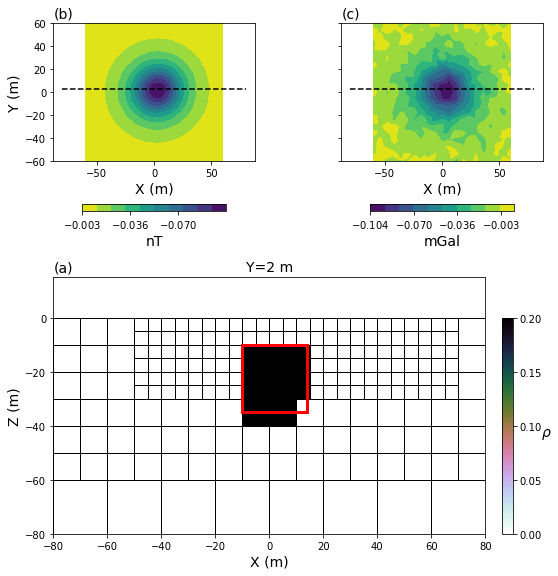

In [6]:
contours = [0.01]
xlim = 80.
midy = int(np.searchsorted(mesh.vectorCCy, 0))
fig = plt.figure(figsize=(8, 8))
ax3 = plt.axes([0., 0.5, 0.5, .5])
plot_map = maps.InjectActiveCells(mesh, actv, np.nan)

# profile coordinates
a = np.r_[-xlim, mesh.vectorCCy[midy]]
b = np.r_[xlim, mesh.vectorCCy[midy]]
# PF.Magnetics.plotModelSections(mesh, mrec_sus, normal='z', ind=-3, subFact=2, scale=0.25, xlim=[-xlim, xlim], ylim=[-xlim, xlim],
#                       title="Esus Model", axs=ax3, vmin=0, vmax=vmax, contours = contours)
# ax3.xaxis.set_visible(False)
vmin, vmax = d_gz.min(), d_gz.max()
im, ax3 = utils.plot2Ddata(
                        surveyGrav.receiver_locations,
                        d_gz, ax=ax3
)


cbar = plt.colorbar(im, ticks=np.linspace(d_gz.min(), d_gz.max(), 4),
            format="${%.3f}$", shrink=0.5, orientation='horizontal')
cbar.set_label("nT", rotation=0, size=14)
ax3.set_xlabel('X (m)', size=14)
ax3.set_ylabel('Y (m)', size=14)
ax3.set_aspect('equal')
# ax3.set_xlabel("")
ax3.set_title("(b)", loc='left', size=14)
# ax3.set_xticks([])
pos = ax3.get_position()
ax3.set_position([pos.x0, pos.y0, pos.height, pos.width])
ax3.plot(np.r_[a[0], b[0]], np.r_[a[1], b[1]], 'k--')


ax3 = plt.axes([0.5, 0.5, 0.5, .5])

im, ax3 = utils.plot2Ddata(
                        surveyGrav.receiver_locations,
                        surveyGrav.dobs, ax=ax3
)

cbar = plt.colorbar(im, ticks=np.linspace(vmin,vmax, 4),
            format="${%.3f}$", shrink=0.5, orientation='horizontal')
cbar.set_label("mGal", rotation=0, size=14)
ax3.set_xlabel('X (m)', size=14)
ax3.set_ylabel('', size=14)
ax3.set_aspect('equal')
# ax3.set_xlabel("")
ax3.set_yticklabels([])
ax3.set_title("(c)", loc='left', size=14)
# ax3.set_xticks([])
pos = ax3.get_position()
ax3.set_position([pos.x0, pos.y0, pos.height, pos.width])
ax3.plot(np.r_[a[0], b[0]], np.r_[a[1], b[1]], 'k--')

# Plot the model
ax2 = plt.axes([0.05, -0.175, 0.75, .75])
vmax = 0.05
im1 = mesh.plotSlice(
    plot_map * den, ind=midy, normal='X', ax=ax2,
    pcolorOpts={"cmap":"cubehelix_r"}, grid=True) 
# cbar.set_label("$\kappa_e$", rotation=0, size=14)
ax2.set_aspect('equal')
ax2.set_xlim([-xlim, xlim])
ax2.set_ylim([-xlim, 15])
ax2.grid(False)

# plotVectorsOctree(mesh, mvec_true, 0, 
#                   axs=ax2, scale=0.4, vec='w', resolution=5, 
#                   normal='Y', actvMap=actvMap, zorder=4,
#                  lims=102.5)
# for midx in locx:
ax2.add_patch(Rectangle(corners[0][::2],corners[1][0] - corners[0][0],corners[1][2] - corners[0][2], facecolor = 'none', edgecolor='r', linewidth=3))
# ax2.grid(color='w', linestyle='--', linewidth=0.5)
loc = ax2.get_position()
ax2.set_position([loc.x0+0.025, loc.y0+0.025, loc.width, loc.height])
ax2.set_xlabel('X (m)', size=14)
ax2.set_ylabel('Z (m)', size=14)
ax2.set_title("(a)", loc='left', size=14)
ax2.set_title("Y=%.0f" % mesh.vectorCCy[midy] + " m", loc='center', size=14)


pos = ax2.get_position()
# cbarAxis = plt.axes([pos.x0+0.4, pos.y0, pos.height, pos.width*0.5])
# cbarAxis.axis('off')
# cbar = plt.colorbar(im2[0], ax = cbarAxis, ticks=np.linspace(0, vmax, 4),
#             format="%.2f", orientation='vertical')
# cbar.set_label("$\kappa_e$", rotation=0, size=14)


# ax2.axis('off')
cbarAxis = plt.axes([pos.x0+0.4, pos.y0, pos.height, pos.width*0.5])
cbarAxis.axis('off')
cbar = plt.colorbar(im1[0], ax = cbarAxis, ticks=np.linspace(0, den.max(), 5),
            format="%.1f", orientation='vertical')
cbar.set_ticklabels(["%.2f" % ii for ii in np.linspace(0, 0.2, 5).tolist()]
)
cbar.set_label("$\\rho$", rotation=0, size=14)
# "cubehelix_r"

plt.savefig("GRAV_Synthetic_True_data_model.png", bbox_inches='tight', dpi=300)

In [15]:
reg.objfcts[0].weights, wr




({'volume': array([512000., 512000., 512000., ..., 512000., 512000., 512000.]),
  'sensitivity': array([0.00086289, 0.0012803 , 0.0012803 , ..., 0.00053173, 0.00053173,
         0.00034226])},
 array([0.00086289, 0.0012803 , 0.0012803 , ..., 0.00053173, 0.00053173,
        0.00034226]))

In [16]:
# Create reduced identity map
idenMap = maps.IdentityMap(nP=nC)

# Create the forward probGravlem
# probGrav = PF.Gravity.GravityIntegral(mesh, rhoMap=idenMap, actInd=actv,
#                                      Jpath='.\\sensGrav.zarr', 
#                                       verbose=False, parallelized='dask')

# Pair the surveyMag and probMaglem and compute data
# surveyGrav.unpair()
# surveyGrav.pair(probGrav)
# wr = np.sum(probGrav.G**2., axis=0) / mesh.cell_volumes[actv] **2.
# wr = wr/wr.max()
# wr **= 0.5

# Create a regularization
reg = regularization.Sparse(mesh, active_cells=actv, mapping=idenMap, gradient_type='components')

# Data misfit function
dmis = data_misfit.L2DataMisfit(simulation=probGrav, data=data_object)

# Add directives to the inversion
opt = optimization.ProjectedGNCG(maxIter=100, lower=0., upper=1.,
                                 maxIterLS=20, maxIterCG=20, tolCG=1e-3)
invProb = inverse_problem.BaseInvProblem(dmis, reg, opt)
betaest = directives.BetaEstimate_ByEig(beta0_ratio=1e+0)

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = directives.Update_IRLS(f_min_change=1e-3, max_irls_iterations=0, chifact_target=1.0)
update_Jacobi = directives.UpdatePreconditioner()
sensitivity_weights = directives.UpdateSensitivityWeights(everyIter=False)
inv = inversion.BaseInversion(invProb,
                              directiveList=[sensitivity_weights, betaest, IRLS, update_Jacobi])

# Run the inversion
m0 = np.ones(nC)*1e-4  # Starting model
mrec_den_l2 = inv.run(m0)
# mrec_den_l2  = invProb.l2model
pred_den = invProb.dpred
beta = invProb.beta.copy()

p_s = [2., 1., 0.]
p_xy = [2., 1., 0.]

models = []
norms = []
for p in p_s:
    for q in p_xy:
        
        # Create a regularization
        reg = regularization.Sparse(mesh, active_cells=actv, mapping=idenMap, gradient_type='components')
        reg.reference_model = np.zeros_like(mrec_den_l2)
        reg.norms = [p, q, q, q]

        # Data misfit function
        dmis = data_misfit.L2DataMisfit(simulation=probGrav, data=data_object)

        # Add directives to the inversion
        opt = optimization.ProjectedGNCG(maxIter=100, lower=0., upper=1.,
                                         maxIterLS=20, maxIterCG=20, tolCG=1e-3)
        invProb = inverse_problem.BaseInvProblem(dmis, reg, opt)
#         betaest = directives.BetaEstimate_ByEig(beta0_ratio=1e+0)

        # Here is where the norms are applied
        # Use pick a treshold parameter empirically based on the distribution of
        #  model parameters
        IRLS = directives.Update_IRLS(f_min_change=1e-3, max_irls_iterations = 30, chifact_target=1.0)
        update_Jacobi = directives.UpdatePreconditioner()
        sensitivity_weights = directives.UpdateSensitivityWeights(everyIter=False)
        betaest = directives.BetaEstimate_ByEig(beta0_ratio=1e+0)
        inv = inversion.BaseInversion(invProb,
                                      directiveList=[sensitivity_weights, betaest, IRLS, update_Jacobi])

        # Run the inversion
#         m0 = np.ones(nC)*1e-4  # Starting model
        models += [inv.run(m0)]
        norms += [p, q]

SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver and solver_opts as the Simulation3DIntegral problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.40e+02  6.64e+03  0.00e+00  6.64e+03    9.66e+01      0              
   1  1.20e+02  3.12e+03  3.35e+00  3.52e+03    6.83e+01      0              
   2  6.01e+01  2.57e+03  6.71e+00  2.97e+03    5.02e+01      0   Skip BFGS  
   3  3

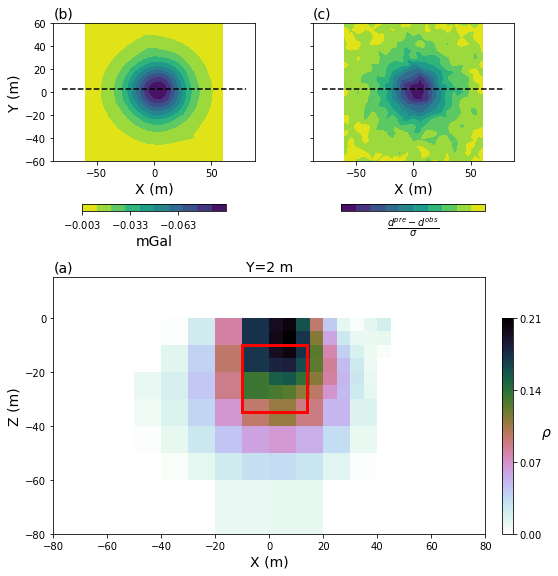

In [17]:
contours = [0.01]
xlim = 80.
midy = int(np.searchsorted(mesh.vectorCCy, 0))
fig = plt.figure(figsize=(8, 8))
ax3 = plt.axes([0., 0.5, 0.5, .5])

dpred = probGrav.fields(mrec_den_l2)

# profile coordinates
a = np.r_[-xlim, mesh.vectorCCy[midy]]
b = np.r_[xlim, mesh.vectorCCy[midy]]
# PF.Magnetics.plotModelSections(mesh, mrec_sus, normal='z', ind=-3, subFact=2, scale=0.25, xlim=[-xlim, xlim], ylim=[-xlim, xlim],
#                       title="Esus Model", axs=ax3, vmin=0, vmax=vmax, contours = contours)
# ax3.xaxis.set_visible(False)
vmin, vmax = dpred.min(), dpred.max()
im, ax3 = utils.plot2Ddata(
                        surveyGrav.receiver_locations,
                        dpred, ax=ax3
    
)


cbar = plt.colorbar(im, ticks=np.linspace(vmin, vmax, 4),
            format="${%.3f}$", shrink=0.5, orientation='horizontal')
cbar.set_label("mGal", rotation=0, size=14)
ax3.set_xlabel('X (m)', size=14)
ax3.set_ylabel('Y (m)', size=14)
ax3.set_aspect('equal')
# ax3.set_xlabel("")
ax3.set_title("(b)", loc='left', size=14)
# ax3.set_xticks([])
pos = ax3.get_position()
ax3.set_position([pos.x0, pos.y0, pos.height, pos.width])
ax3.plot(np.r_[a[0], b[0]], np.r_[a[1], b[1]], 'k--')


ax3 = plt.axes([0.45, 0.5, 0.5, .5])
vmin, vmax = -3,3
im, ax3 = utils.plot2Ddata(
                        surveyGrav.receiver_locations,
                        surveyGrav.dobs, ax=ax3
)

cbar = plt.colorbar(im, ticks=np.linspace(vmin,vmax, 4),
            format="${%.1f}$", shrink=0.5, orientation='horizontal')
cbar.set_label("$\\frac{d^{pre} - d^{obs}}{\sigma}$", rotation=0, size=14)
ax3.set_xlabel('X (m)', size=14)
ax3.set_ylabel('', size=14)
ax3.set_aspect('equal')
# ax3.set_xlabel("")
ax3.set_title("(c)", loc='left', size=14)
ax3.set_yticklabels([])
pos = ax3.get_position()
ax3.set_position([pos.x0, pos.y0, pos.height, pos.width])
ax3.plot(np.r_[a[0], b[0]], np.r_[a[1], b[1]], 'k--')

# Plot the model
ax2 = plt.axes([0.05, -0.175, 0.75, .75])
vmax = mrec_den_l2.max()
vmin = mrec_den_l2.min()
# im2 = mesh.plotSlice(
#     actvMap * sus, ind=midy, normal='Y', ax=ax2,
#     pcolorOpts={"cmap":"pink_r"}, grid=True) 

im1 = mesh.plotSlice(
    plot_map * mrec_den_l2, ind=midy, normal='Y', ax=ax2,
    pcolorOpts={"cmap":"cubehelix_r"}) 
# cbar.set_label("$\kappa_e$", rotation=0, size=14)
ax2.set_aspect('equal')
ax2.set_xlim([-xlim, xlim])
ax2.set_ylim([-xlim, 15])
ax2.grid(False)

# plotVectorsOctree(mesh, mvec_true, 0, axs=ax2, scale=0.4, vec='w', resolution=10, normal='Y', actvMap=actvMap, zorder=4)
# for midx in locx:
ax2.add_patch(Rectangle(corners[0][::2],corners[1][0] - corners[0][0],corners[1][2] - corners[0][2], facecolor = 'none', edgecolor='r', linewidth=3))
# ax2.grid(color='w', linestyle='--', linewidth=0.5)
loc = ax2.get_position()
ax2.set_position([loc.x0+0.025, loc.y0+0.025, loc.width, loc.height])
ax2.set_xlabel('X (m)', size=14)
ax2.set_ylabel('Z (m)', size=14)
ax2.set_title("(a)", loc='left', size=14)
ax2.set_title("Y=%.0f" % mesh.vectorCCy[midy] + " m", loc='center', size=14)

pos = ax2.get_position()
cbarAxis = plt.axes([pos.x0+0.4, pos.y0, pos.height, pos.width*0.5])
cbarAxis.axis('off')
cbar = plt.colorbar(im1[0], ax = cbarAxis, ticks=np.linspace(0, vmax, 4),
            format="%.2f", orientation='vertical')
cbar.set_label("$\\rho$", rotation=0, size=14)


# ax2.axis('off')
# cbarAxis = plt.axes([pos.x0+0.5, pos.y0, pos.height, pos.width*0.5])
# cbarAxis.axis('off')
# cbar = plt.colorbar(im1[0], ax = cbarAxis, ticks=np.linspace(0, den.max(), 5),
#             format="%.1f", orientation='vertical')
# cbar.set_ticklabels(["%.2f" % ii for ii in np.linspace(0, 0.2, 5).tolist()]
# )
# cbar.set_label("$\\rho$", rotation=0, size=14)
# "cubehelix_r"

plt.savefig("Grav_Inv_l2model.png", bbox_inches='tight', dpi=300)

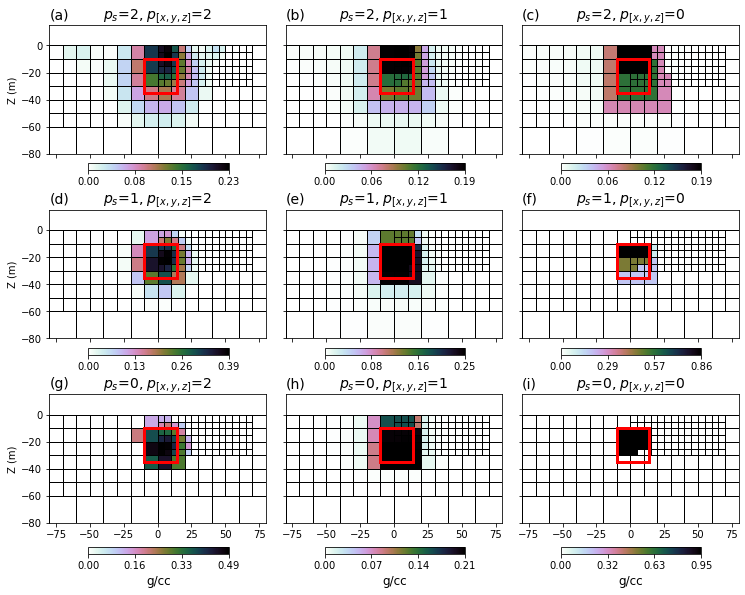

In [9]:
xlim = 80
midy = int(np.searchsorted(mesh.vectorCCy,0))
vmax = mrec_den_l2.max()
vmin = mrec_den_l2.min()
fig = plt.figure(figsize=(12, 10))
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(b)']
count = -1
for p in p_s:
    for q in p_xy:
        
        count += 1
        ax1 = plt.subplot(3,3,count+1)
        # ax1, im2, cbar = Utils.PlotUtils.plotModelSections(mesh, mrec_den_l2, normal='y',
        #                                ind=midy, axs=ax1,
        #                                scale = 0.3, vec ='w',
        #                                vmin=-vmax, vmax=vmax, colorbar=True)

        im2 = mesh.plotSlice(
            plot_map * models[count], ind=midy, normal='Y', ax=ax1,
            pcolorOpts={"cmap":"cubehelix_r"}, grid=True) 
#         cbar.set_label("$\kappa$", rotation=0, size=14)
        ax1.set_aspect('equal')
        ax1.set_xlim([-xlim, xlim])
        ax1.set_ylim([-xlim, 15])
        ax1.set_xlabel('')
        ax1.set_ylabel('Z (m)')
        if count not in [6,7,8]:
            
            ax1.set_xlabel("")
            ax1.set_xticklabels([])
            
        if count not in [0,3,6]:
            
            ax1.set_ylabel("")
            ax1.set_yticklabels([])
        ax1.add_patch(Rectangle(corners[0][::2],corners[1][0] - corners[0][0],corners[1][2] - corners[0][2], facecolor = 'none', edgecolor='r', linewidth=3))
        ax1.grid(color='w', linestyle='--', linewidth=0.5)
        loc = ax1.get_position()
        if count in [3,4,5]:
            ax1.set_position([loc.x0, loc.y0+.01, loc.width*1.1, loc.height*1.1])
            cbarAxis = plt.axes([loc.x0+0.045, loc.y0-0.02, loc.height, loc.width*0.5])
        elif count in [6,7,8]:
            ax1.set_position([loc.x0, loc.y0+.02, loc.width*1.1, loc.height*1.1])
            cbarAxis = plt.axes([loc.x0+0.045, loc.y0-0.03, loc.height, loc.width*0.5])
        else:
            ax1.set_position([loc.x0, loc.y0, loc.width*1.1, loc.height*1.1])
            cbarAxis = plt.axes([loc.x0+0.045, loc.y0-0.03, loc.height, loc.width*0.5])

        cbarAxis.axis('off')
        cbar = plt.colorbar(im2[0], ax = cbarAxis,
                    format="%.2f", orientation='horizontal')
        cbar.set_ticks(np.linspace(0, models[count].max(), 4))
        if count in [6,7,8]:
            cbar.set_label("g/cc", size=12)



            #         if count not in [6,7,8]:
#             cbar = plt.colorbar(im2[0], format="%.2f", orientation='horizontal', shrink=0.5, pad=0.03)
        
#         else:

            
        
        ax1.grid(False)
        ax1.set_title(labels[count], loc='left', size=14)
#         Utils.PlotUtils.plotProfile(
#             xyzLoc, a, b, 21, fig=fig,
#             ax=ax1, coordinate_system='xProfile',
#             plotStr='k.'
#         )
#         Utils.PlotUtils.plotProfile(
#             topo, a, b, 21, fig=fig,
#             ax=ax1, coordinate_system='xProfile',
#         )
        # ax1.set_xlabel("")
        ax1.set_title("$p_s$=%i" % p + ", $p_{[x,y,z]}$=%i" % q, loc='center', size=14)
        # ax1.set_xticks([])



plt.savefig("Grav_Inv_modelSpace_lenScaled_cellDiff_newEps.png", bbox_inches='tight', dpi=300)

In [56]:
count



8

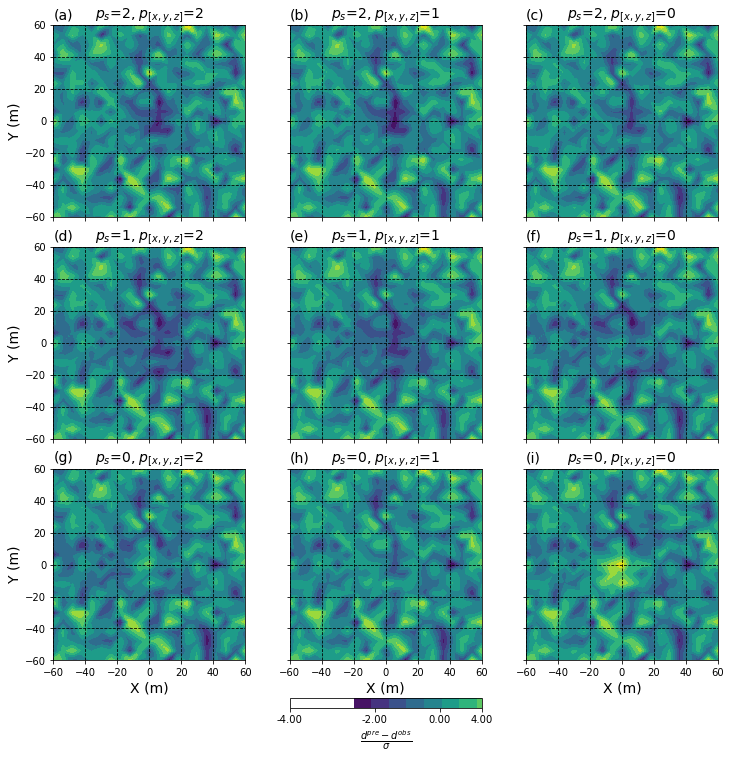

In [11]:
xlim = 80
midy = int(np.searchsorted(mesh.vectorCCy,0))
vmax = 4
vmin = -4
fig = plt.figure(figsize=(12, 12))
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(b)']
count = -1
for p in p_s:
    for q in p_xy:

        count += 1
        ax1 = plt.subplot(3,3,count+1)
        # ax1, im2, cbar = Utils.PlotUtils.plotModelSections(mesh, mrec_den_l2, normal='y',
        #                                ind=midy, axs=ax1,
        #                                scale = 0.3, vec ='w',
        #                                vmin=-vmax, vmax=vmax, colorbar=True)
        dpred = probGrav.fields(models[count])
        im, ax1 = utils.plot2Ddata(
            surveyGrav.receiver_locations,
            (surveyGrav.dobs-dpred)/surveyGrav.std, ax=ax1
        )
        ax1.set_xlabel('', size=14)
        ax1.set_ylabel('', size=14)
        ax1.set_aspect('equal')
        # ax1.set_xlabel("")
        ax1.set_title(labels[count], loc='left', size=14)
        ax1.set_title("$p_s$=%i" % p + ", $p_{[x,y,z]}$=%i" % q, loc='center', size=14)
        ax1.grid(True, linestyle='--', color='k')
        loc = ax1.get_position()
        if count in [3,4,5]:
            ax1.set_position([loc.x0, loc.y0+.01, loc.width, loc.height])
            ax1.set_xticklabels([])
        elif count in [6,7,8]:
            ax1.set_position([loc.x0, loc.y0+.02, loc.width, loc.height])
            
            ax1.set_xlabel('X (m)', size=14)
        else:
            ax1.set_position([loc.x0, loc.y0, loc.width, loc.height])
            ax1.set_xticklabels([])

        if count == 7:
            cbarAxis = plt.axes([loc.x0, loc.y0-0.04, loc.height, loc.width*0.5])
            cbarAxis.axis('off')
            cbar = plt.colorbar(im, ax = cbarAxis,
                    format="%.2f", orientation='horizontal')
            cbar.set_ticks(np.linspace(vmin, vmax, 5))
            cbar.set_label("$\\frac{d^{pre} - d^{obs}}{\sigma}$", rotation=0, size=14)
            
        if count in [0,3,6]:
            ax1.set_ylabel('Y (m)', size=14)
        else:
            ax1.set_yticklabels([])



plt.savefig("Grav_Inv_modelSpace_dpred.png", bbox_inches='tight', dpi=300)




In [125]:
def getDiffOpRot(mesh, psi, theta, phi, vec, indActive, forward=True):

    import scipy as sp
    assert mesh.dim > 1, 'Only for mesh 2D and 3D'

    def getCellNeighbors(mesh):
        Dx = mesh._cellGradxStencil
        Dy = mesh._cellGradyStencil
        # Get the current IJ of the stencil derive
        Ix, Jx, _ = sp.sparse.find(Dx)
        Iy, Jy, _ = sp.sparse.find(Dy)
        jx = np.sort(Jx[np.argsort(Ix)].reshape((int(Ix.shape[0]/2), 2)), axis=1)
        jy = np.sort(Jy[np.argsort(Iy)].reshape((int(Iy.shape[0]/2), 2)), axis=1)
        jx_bck = np.c_[jx[:, 1], jx[:, 0]]
        jy_bck = np.c_[jy[:, 1], jy[:, 0]]

        maxInd = np.max([jx.max(), jy.max()])

        if mesh.dim == 3:
            Dz = mesh._cellGradzStencil
            Iz, Jz, _ = sp.sparse.find(Dz)
            jz = np.sort(Jz[np.argsort(Iz)].reshape((int(Iz.shape[0]/2), 2)), axis=1)
            jz_bck = np.c_[jz[:, 1], jz[:, 0]]

            maxInd = np.max([jz.max(), maxInd])


        # Cycle through the gradients forward and backward to deal with multiple
        # levels on Tree mesh
        # Pre-allocate index arrays
        jAll = []  # Store
        div_xy = np.ones(maxInd+1, dtype='int')*-1
        div_yx = np.ones(maxInd+1, dtype='int')*-1
        div_xyb = np.ones(maxInd+1, dtype='int')*-1
        div_yxb = np.ones(maxInd+1, dtype='int')*-1

        div_xy[jy[:, 0]] = jy[:, 1]  # Find y neigbour of x adjacent
        div_yx[jx[:, 1]] = jx[:, 0]  # Find x neigbour of y adjacent

        div_xyb[jy_bck[:, 0]] = jy_bck[:, 1]  # Find y neigbour of x adjacent backward
        div_yxb[jx_bck[:, 1]] = jx_bck[:, 0]  # Find x neigbour of y adjacent backward

        jAll += [jx]
        jAll += [jy]

        jAll += [np.c_[jx[:, 0], div_xy[jx[:, 1]]]]
        jAll += [np.c_[jx[:, 1], div_xy[jx[:, 0]]]]

        jAll += [np.c_[div_yx[jy[:, 0]], jy[:, 1]]]
        jAll += [np.c_[div_yx[jy[:, 1]], jy[:, 0]]]

        # Repeat backward for Treemesh
        jAll += [jx_bck]
        jAll += [jy_bck]

        jAll += [np.c_[jx_bck[:, 0], div_xyb[jx_bck[:, 1]]]]
        jAll += [np.c_[jx_bck[:, 1], div_xyb[jx_bck[:, 0]]]]

        # Stack all and keep only unique pairs
        jAll = np.vstack(jAll)
        jAll = np.unique(jAll, axis=0)

        # Remove all the -1 for TreeMesh
        jAll = jAll[(jAll[:, 0] != -1) & (jAll[:, 1] != -1), :]

        # Use all the neighbours on the xy plane to find neighbours in z
        if mesh.dim == 3:
            jAllz = []
            div_z = np.ones(maxInd+1, dtype='int')*-1
            div_zb = np.ones(maxInd+1, dtype='int')*-1

            div_z[jz[:, 0]] = jz[:, 1]
            div_zb[jz_bck[:, 0]] = jz_bck[:, 1]

            jAllz += [jz]
            jAllz += [jz_bck]

            jAllz += [np.c_[jAll[:, 0], div_z[jAll[:, 1]]]]
            jAllz += [np.c_[jAll[:, 1], div_z[jAll[:, 0]]]]

            jAllz += [np.c_[jAll[:, 0], div_zb[jAll[:, 1]]]]
            jAllz += [np.c_[jAll[:, 1], div_zb[jAll[:, 0]]]]

            # Stack all and keep only unique pairs
            jAll = np.vstack([jAll, np.vstack(jAllz)])
            jAll = np.unique(jAll, axis=0)

            # Remove all the -1 for TreeMesh
            jAll = jAll[(jAll[:, 0] != -1) & (jAll[:, 1] != -1), :]

        return jAll

    hx = mesh.h_gridded[:, 0]
    hy = mesh.h_gridded[:, 1]

    if isinstance(phi, float):
        phi = np.ones(mesh.nC) * phi
    phi = np.arctan2((np.sin(phi)/hy), (np.cos(phi)/hx))

    if mesh.dim == 3:
        hz = mesh.h_gridded[:, 2]

        if isinstance(theta, float):
            theta = np.ones(mesh.nC) * theta
        theta = np.arctan2((np.sin(theta)/hz), (np.cos(theta)/hx))

        if isinstance(psi, float):
            psi = np.ones(mesh.nC) * psi
        psi = np.arctan2((np.sin(psi)/hz), (np.cos(psi)/hy))

    if forward:
        ind = 1
    else:
        ind = -1

    if mesh.dim == 2:
        if vec == 'X':
            px = np.kron(np.ones(mesh.nC), np.c_[ind, 0])

        elif vec == 'Y':
            px = np.kron(np.ones(mesh.nC), np.c_[0, ind])

    if mesh.dim == 3:

        if vec == 'X':
            px = np.kron(np.ones(mesh.nC), np.c_[ind, 0, 0])
        elif vec == 'Y':
            px = np.kron(np.ones(mesh.nC), np.c_[0, ind, 0])
        else:
            px = np.kron(np.ones(mesh.nC), np.c_[0, 0, ind])

    if mesh.dim == 2:
        rza = mkvc(np.c_[np.cos(phi), np.cos(phi)].T)
        rzb = mkvc(np.c_[np.sin(phi), np.zeros(mesh.nC)].T)
        rzc = mkvc(np.c_[-np.sin(phi), np.zeros(mesh.nC)].T)
        Rz = sp.sparse.diags([rzb[:-1], rza, rzc[:-1]], [-1, 0, 1])
        rx = (Rz*px.T).reshape((mesh.nC, 2))
    else:
        # Create sparse rotation operators
        rxa = mkvc(np.c_[np.ones(mesh.nC), np.cos(psi), np.cos(psi)].T)
        rxb = mkvc(np.c_[np.zeros(mesh.nC), np.sin(psi), np.zeros(mesh.nC)].T)
        rxc = mkvc(np.c_[np.zeros(mesh.nC), -np.sin(psi), np.zeros(mesh.nC)].T)
        Rx = sp.sparse.diags([rxb[:-1], rxa, rxc[:-1]], [-1, 0, 1])

        rya = mkvc(np.c_[np.cos(theta), np.ones(mesh.nC), np.cos(theta)].T)
        ryb = mkvc(np.c_[np.sin(theta), np.zeros(mesh.nC), np.zeros(mesh.nC)].T)
        ryc = mkvc(np.c_[-np.sin(theta), np.zeros(mesh.nC), np.zeros(mesh.nC)].T)
        Ry = sp.sparse.diags([ryb[:-2], rya, ryc[:-2]], [-2, 0, 2])

        rza = mkvc(np.c_[np.cos(phi), np.cos(phi), np.ones(mesh.nC)].T)
        rzb = mkvc(np.c_[np.sin(phi), np.zeros(mesh.nC), np.zeros(mesh.nC)].T)
        rzc = mkvc(np.c_[-np.sin(phi), np.zeros(mesh.nC), np.zeros(mesh.nC)].T)
        Rz = sp.sparse.diags([rzb[:-1], rza, rzc[:-1]], [-1, 0, 1])

        # Rotate all cell vectors
        rx = (Rz*(Ry*(Rx*px.T))).reshape((mesh.nC, 3))

    jd = getCellNeighbors(mesh)
    # Move the bottom-SW and top-NE nodes of stencil cell
    nBSW = mesh.gridCC[jd[:, 0], :] - mesh.h_gridded[jd[:, 0], :]/2 + rx[jd[:, 0], :]*mesh.h_gridded[jd[:, 0], :]
    nTNE = mesh.gridCC[jd[:, 0], :] + mesh.h_gridded[jd[:, 0], :]/2 + rx[jd[:, 0], :]*mesh.h_gridded[jd[:, 0], :]

    # Get corners for neighbours
    sBSW = mesh.gridCC[jd[:, 1], :] - mesh.h_gridded[jd[:, 1], :]/2
    sTNE = mesh.gridCC[jd[:, 1], :] + mesh.h_gridded[jd[:, 1], :]/2

    # Compute fractional volumes with base stencil
    V = (
            np.max([
                np.min([sTNE[:, 0], nTNE[:, 0]], axis=0) -
                np.max([sBSW[:, 0], nBSW[:, 0]], axis=0),
                np.zeros(jd.shape[0])], axis=0) *
            np.max([
                np.min([sTNE[:, 1], nTNE[:, 1]], axis=0) -
                np.max([sBSW[:, 1], nBSW[:, 1]], axis=0),
                np.zeros(jd.shape[0])], axis=0))

    if mesh.dim == 3:
        V *= np.max([
                np.min([sTNE[:, 2], nTNE[:, 2]], axis=0) -
                np.max([sBSW[:, 2], nBSW[:, 2]], axis=0),
                np.zeros(jd.shape[0])], axis=0)

    # Remove all rows of zero
    ind = (V > 0) * (jd[:, 0] != jd[:, 1])
    jd = jd[ind, :]
    V = V[ind]

    # Normalize rows
    Dx_total = sp.sparse.csr_matrix((V, (jd[:, 0], jd[:, 1])), shape=(mesh.nC, mesh.nC))

    # Remove inactives
    Pac = Utils.speye(mesh.nC)[:, indActive]

    nC = int(indActive.sum())

    Dx_total = Pac.T * Dx_total * Pac
    Vrow = mkvc(sp.sum(Dx_total, axis=1))
    Vrow[Vrow > 0] = 1. / Vrow[Vrow > 0]
    Dx_total = sdiag(Vrow) * Dx_total


    # Get the elements back and put on indidual rows
    I, J, V = sp.sparse.find(Dx_total)

    rows = np.arange(I.shape[0])
    Dx1 = sp.sparse.csr_matrix((V, (rows, I)), shape=(rows.shape[0], nC))

    Dx2 = sp.sparse.csr_matrix((-V, (rows, J)), shape=(rows.shape[0], nC))




    # diag = np.ones(mesh.nC)
    # diag[V == 0] = 0

    # Dx = (sdiag(diag) + Dx2)
    return (Dx1 + Dx2)


In [126]:
# norms = np.c_[0, 0., 0., 0.]
norms = [np.c_[1,2,2,2], np.c_[0, 0., 0., 0.], np.c_[0, 0., 0., 0.]]
alpha = [100, 1 , 1]
surveyGrav.std = wd*4.
shutil.rmtree('.\\sensGrav.zarr')
# Create the forward probGravlem
probGrav = PF.Gravity.GravityIntegral(mesh, rhoMap=idenMap, actInd=actv,
                                     Jpath='.\\sensGrav.zarr', 
                                      verbose=False, parallelized='dask')

# Pair the surveyMag and probMaglem and compute data
surveyGrav.unpair()
surveyGrav.pair(probGrav)
mrec27pt = []
for aa, ii in enumerate([45,45,30]):
    theta = np.ones(mesh.nC)*np.deg2rad(0)
    phi = np.ones(mesh.nC)*np.deg2rad(ii)

    indActive = np.zeros(mesh.nC, dtype=bool)
    indActive[actv] = True

    # This is for the aircells
    Pac = Utils.speye(mesh.nC)[:, indActive]

    Dx1 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X')
    Dy1 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y')
    Dz1 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z')

    Dx1 = Pac.T * Dx1 * Pac
    Dy1 = Pac.T * Dy1 * Pac
    Dz1 = Pac.T * Dz1 * Pac


    Dx2 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X', forward=False)
    Dy2 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y', forward=False)
    Dz2 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z', forward=False)

    Dx2 = Pac.T * Dx2 * Pac
    Dy2 = Pac.T * Dy2 * Pac
    Dz2 = Pac.T * Dz2 * Pac

    # Inversion
    wr = probGrav.getJtJdiag(np.ones(nC))**0.5
    wr = (wr/np.max(wr))


    # Create a regularization
    reg1 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap, gradientType='components')
#     reg1.alpha_s = 0.5
    reg1.alpha_x = alpha[aa]
#     reg1.alpha_y = 1
#     reg1.alpha_z = 1
    
    reg1.objfcts[1].regmesh._cellDiffxStencil = Dx1
    reg1.objfcts[1].regmesh._aveCC2Fx = speye(nC)
#     I,J,_= sp.find(Dx1)
#     reg1.objfcts[1].regmesh._aveCC2Fx = sp.csr_matrix((np.ones(I.shape[0])*0.5, (I, J)), shape=(Dx1.shape))


    reg1.objfcts[2].regmesh._cellDiffyStencil = Dy1
    reg1.objfcts[2].regmesh._aveCC2Fy = speye(nC)
#     I,J,_= sp.find(Dy1)
#     reg1.objfcts[2].regmesh._aveCC2Fy = sp.csr_matrix((np.ones(I.shape[0])*0.5, (I, J)), shape=(Dy1.shape))


    reg1.objfcts[3].regmesh._cellDiffzStencil = Dz1
    reg1.objfcts[3].regmesh._aveCC2Fz = speye(nC)
#     I,J,_= sp.find(Dz1)
#     reg1.objfcts[3].regmesh._aveCC2Fz = sp.csr_matrix((np.ones(I.shape[0])*0.5, (I, J)), shape=(Dz1.shape))

    reg1.norms = norms[aa]
    reg1.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

    reg2 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap, gradientType='components')

    reg2.objfcts[1].regmesh._cellDiffxStencil = Dx2
    reg2.objfcts[1].regmesh._aveCC2Fx = speye(nC)
#     I,J,_= sp.find(Dx2)
#     reg2.objfcts[1].regmesh._aveCC2Fx = sp.csr_matrix((np.ones(I.shape[0])*0.5, (I, J)), shape=(Dx2.shape))


    reg2.objfcts[2].regmesh._cellDiffyStencil = Dy2
    reg2.alpha_x = alpha[aa]
#     reg2.alpha_x = 1
#     reg2.alpha_y = 1
#     reg2.alpha_z = 1
    reg2.objfcts[2].regmesh._aveCC2Fy = speye(nC)
#     I,J,_= sp.find(Dy2)
#     reg2.objfcts[2].regmesh._aveCC2Fy = sp.csr_matrix((np.ones(I.shape[0])*0.5, (I, J)), shape=(Dy2.shape))


    reg2.objfcts[3].regmesh._cellDiffzStencil = Dz2
    reg2.objfcts[3].regmesh._aveCC2Fz = speye(nC)
#     I,J,_= sp.find(Dz2)
#     reg2.objfcts[3].regmesh._aveCC2Fz = sp.csr_matrix((np.ones(I.shape[0])*0.5, (I, J)), shape=(Dz2.shape))

    reg2.norms = norms[aa]
    reg2.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

    reg= reg1 + reg2

    # Data misfit function
    dmis = DataMisfit.l2_DataMisfit(surveyGrav)
    dmis.W = 1./surveyGrav.std

    # Add directives to the inversion
    opt = Optimization.ProjectedGNCG(maxIter=35, lower=-1, upper=1.,
                                     maxIterLS=20, maxIterCG=10, tolCG=1e-4)
    invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta=1e+6)
    betaest = Directives.BetaEstimate_ByEig()

    # Here is where the norms are applied
    # Use pick a treshold parameter empirically based on the distribution of
    #  model parameters
    IRLS = Directives.Update_IRLS(f_min_change=1e-4, minGNiter=1, maxIRLSiter=20, beta_tol=0.5, betaSearch=False)
    update_Jacobi = Directives.UpdatePreconditioner()

    inv = Inversion.BaseInversion(invProb,
                                  directiveList=[IRLS, update_Jacobi])

    # Run the inversion
    m0 = np.ones(nC)*1e-4  # Starting model
    probGrav.model = m0
    mrec27pt += [inv.run(m0)]

Dask:
n_cpu:  8
n_chunks:  1
Chunk sizes:  441 12420
RAM/tile:  0.35054208000000003
Total RAM (x n_cpu):  2.8043366400000003
Saving G to zarr: .\sensGrav.zarr
[########################################] | 100% Completed |  3.9s
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+06  3.85e+02  1.56e-07  3.85e+02    1.06e+02      0              
Start CG solve
CG solve time: 1.3449995517730713
   1  5.00e+05  3.60e+02  1.22e-05  3.66e+02    9.82e+01      0              
Start CG solve
CG solve time: 1.3270032405853271
   2  2.50e+05  3.40

# Define Sparse regularization with cross terms - Li DWO


In [116]:
import properties
class SparseRot(Regularization.BaseComboRegularization):
    """
    The regularization is:

    .. math::

        R(m) = \\frac{1}{2}\mathbf{(m-m_\\text{ref})^\\top W^\\top R^\\top R
        W(m-m_\\text{ref})}

    where the IRLS weight

    .. math::

        R = \eta TO FINISH LATER!!!

    So the derivative is straight forward:

    .. math::

        R(m) = \mathbf{W^\\top R^\\top R W (m-m_\\text{ref})}

    The IRLS weights are recomputed after each beta solves.
    It is strongly recommended to do a few Gauss-Newton iterations
    before updating.
    """
    def __init__(
        self, mesh, rotFact, derivX, derivY, derivZ,
        alpha_s=1.0, alpha_x=1.0, alpha_y=1.0, alpha_z=1.0, component='normal',
        **kwargs
    ):

        nC = int(indActive.sum())
#         print(rotFact, alpha_x, alpha_y, alpha_z)
        objfcts = [
            Regularization.SparseSmall(mesh=mesh, **kwargs),
        ]

        
        if component == 'normal':
            objfcts.append(SparseDeriv(
                mesh=mesh, derivA=derivX, derivB=derivX, orientation='x', **kwargs))

            objfcts.append(SparseDeriv(
                mesh=mesh, derivA=derivY, derivB=derivY, orientation='y', **kwargs))

            objfcts.append(SparseDeriv(
                mesh=mesh, derivA=derivZ, derivB=derivZ, orientation='z', **kwargs))
            
            scale_x = (
                alpha_x * rotFact[0, 0]**2. + 
                alpha_y * rotFact[1, 0]**2. +
                alpha_z * rotFact[2, 0]**2.)
            
            scale_y = (
                alpha_x * rotFact[0, 1]**2. + 
                alpha_y * rotFact[1, 1]**2. +
                alpha_z * rotFact[2, 1]**2.)
            
            scale_z = (
                alpha_x * rotFact[0, 2]**2. + 
                alpha_y * rotFact[1, 2]**2. +
                alpha_z * rotFact[2, 2]**2.)
            
        else:
            objfcts.append(SparseDeriv(
                mesh=mesh, derivA=derivX, derivB=derivY, orientation='x', **kwargs))

            objfcts.append(SparseDeriv(
                mesh=mesh, derivA=derivY, derivB=derivZ, orientation='y', **kwargs))

            objfcts.append(SparseDeriv(
                mesh=mesh, derivA=derivX, derivB=derivZ, orientation='z', **kwargs))
        
            scale_x = 2*(
                alpha_x * rotFact[0, 0] * rotFact[0, 1] + 
                alpha_y * rotFact[1, 0] * rotFact[1, 1] +
                alpha_z * rotFact[2, 0] * rotFact[2, 1])
            
            scale_y = 2*(
                alpha_x * rotFact[0, 1] * rotFact[0, 2] + 
                alpha_y * rotFact[1, 1] * rotFact[1, 2] +
                alpha_z * rotFact[2, 1] * rotFact[2, 2])
            
            scale_z = 2*(
                alpha_x * rotFact[0, 0] * rotFact[0, 2] + 
                alpha_y * rotFact[1, 0] * rotFact[1, 2] +
                alpha_z * rotFact[2, 0] * rotFact[2, 2])
            
        objfcts[1].regmesh._aveCC2Fx = speye(nC)
        objfcts[2].regmesh._aveCC2Fy = speye(nC)
        objfcts[3].regmesh._aveCC2Fz = speye(nC)
        
        print(scale_x, scale_y, scale_z)
        super(SparseRot, self).__init__(
            mesh=mesh, objfcts=objfcts,
            alpha_s=alpha_s, 
            alpha_x=scale_x, 
            alpha_y=scale_y, 
            alpha_z=scale_z,
            **kwargs
        )

        self.objfcts[1].regmesh._aveCC2Fx = speye(nC)
        self.objfcts[2].regmesh._aveCC2Fy = speye(nC)
        self.objfcts[3].regmesh._aveCC2Fz = speye(nC)
        
        # Utils.setKwargs(self, **kwargs)

    # Properties
    norms = properties.Array(
        "Norms used to create the sparse regularization",
        default=np.c_[2., 2., 2., 2.], shape={('*', '*')}
    )

    eps_p = properties.Float(
        "Threshold value for the model norm", required=True
        )

    eps_q = properties.Float(
        "Threshold value for the model gradient norm", required=True
        )

    model = properties.Array("current model", dtype=float)

    gamma = properties.Float(
        "Model norm scaling to smooth out convergence", default=1.
    )

    space = properties.String(
        "type of model", default='linear'
    )

    gradientType = properties.String(
        "type of gradient", default='components'
    )

    scales = properties.Array(
        "General nob for scaling",
        default=np.c_[1., 1., 1., 1.], shape={('*', '*')}
    )

    # Give the option to scale or not
    scaledIRLS = properties.Bool(
        "Scale the gradients of the IRLS norms",
        default=True
    )

    # Save the l2 result during the IRLS
    l2model = None

    @properties.validator('norms')
    def _validate_norms(self, change):
        if change['value'].shape[0] == 1:
            change['value'] = np.kron(np.ones((self.regmesh.Pac.shape[1], 1)), change['value'])
        elif change['value'].shape[0] > 1:
            assert change['value'].shape[0] == self.regmesh.Pac.shape[1], (
                "Vector of norms must be the size of active model parameters ({})"
                "The provided vector has length "
                "{}".format(
                    self.regmesh.Pac.shape[0], len(change['value'])
                )
            )

    # Observers
    @properties.observer('norms')
    def _mirror_norms_to_objfcts(self, change):

        self.objfcts[0].norm = change['value'][:, 0]
        for i, objfct in enumerate(self.objfcts[1:]):
            Ave = getattr(objfct.regmesh, 'aveCC2F{}'.format(objfct.orientation))
            objfct.norm = Ave*change['value'][:,i+1]

    @properties.observer('model')
    def _mirror_model_to_objfcts(self, change):
        for objfct in self.objfcts:
            objfct.model = change['value']

    @properties.observer('gamma')
    def _mirror_gamma_to_objfcts(self, change):
        for objfct in self.objfcts:
            objfct.gamma = change['value']

    @properties.observer('eps_p')
    def _mirror_eps_p_to_smallness(self, change):
        for objfct in self.objfcts:
            if isinstance(objfct, Regularization.SparseSmall):
                objfct.epsilon = change['value']

    @properties.observer('eps_q')
    def _mirror_eps_q_to_derivs(self, change):
        for objfct in self.objfcts:
            if isinstance(objfct, SparseDeriv):
                objfct.epsilon = change['value']

    @properties.observer('space')
    def _mirror_space_to_objfcts(self, change):
        for objfct in self.objfcts:
            objfct.space = change['value']

    @properties.observer('scaledIRLS')
    def _mirror_scaledIRLS_to_objfcts(self, change):
        for objfct in self.objfcts:
            objfct.scaledIRLS = change['value']

    @properties.observer('gradientType')
    def _mirror_gradientType_to_objfcts(self, change):
        for objfct in self.objfcts:
            objfct.gradientType = change['value']

    @properties.validator('scales')
    def _validate_scales(self, change):
        if change['value'].shape[0] == 1:
            change['value'] = np.kron(np.ones((self.regmesh.Pac.shape[1], 1)), change['value'])
        elif change['value'].shape[0] > 1:
            assert change['value'].shape[0] == self.regmesh.Pac.shape[1], (
                "Vector of scales must be the size of active model parameters ({})"
                "The provided vector has length "
                "{}".format(
                    self.regmesh.Pac.shape[0], len(change['value'])
                )
            )

    # Observers
    @properties.observer('scales')
    def _mirror_scale_to_objfcts(self, change):
        for i, objfct in enumerate(self.objfcts):
            objfct.scale = change['value'][:,i]
            
class SparseDeriv(Regularization.BaseSparse):
    """
    Base Class for sparse regularization on first spatial derivatives
    """

    def __init__(self, mesh, derivA, derivB, orientation='x', **kwargs):
        self.orientation = orientation
        self.derivA = derivA
        self.derivB = derivB
        super(SparseDeriv, self).__init__(mesh=mesh, **kwargs)


    mrefInSmooth = properties.Bool(
        "include mref in the smoothness calculation?", default=False
    )

    # Give the option to scale or not
    scaledIRLS = properties.Bool(
        "Scale the gradients of the IRLS norms",
        default=True
    )

    @Utils.timeIt
    def __call__(self, m):
        """
        We use a weighted 2-norm objective function

        .. math::

            r(m) = \\frac{1}{2}
        """

        if self.mrefInSmooth:

            f_m = self._delta_m(m)

        else:
            f_m = m

        if self.scale is None:
            self.scale = np.ones(self.mapping.shape[0])

        r = self.W * (self.derivA * (self.mapping * f_m))
        rT = self.W * (self.derivB * (self.mapping * f_m))

        
        
        return 0.5*rT.dot(r)

    @Utils.timeIt
    def deriv2(self, m, v=None):
        """
        Second derivative

        :param numpy.array m: geophysical model
        :param numpy.array v: vector to multiply
        :rtype: scipy.sparse.csr_matrix
        :return: WtW, or if v is supplied WtW*v (numpy.ndarray)

        The regularization is:

        .. math::

            R(m) = \\frac{1}{2}\mathbf{(m-m_\\text{ref})^\\top W^\\top
            W(m-m_\\text{ref})}

        So the second derivative is straight forward:

        .. math::

            R(m) = \mathbf{W^\\top W}

        """
        mD = self.mapping.deriv(self._delta_m(m))
        if v is None:
            return mD.T * self.derivB.T * self.W.T * self.W * (self.derivA * mD)

        return mD.T * self.derivB.T * ( self.W.T * ( self.W * (self.derivA * mD * v) ) )
    
    def R(self, m):
        # if R is stashed, return that instead
        if getattr(self, 'stashedR') is not None:
            return self.stashedR

        # Ave = getattr(self.regmesh, 'aveCC2F{}'.format(self.orientation))


        eta = np.ones_like(m)

        if self.scaledIRLS:
            # Eta scaling is important for mix-norms...do not mess with it
            maxVal = np.ones_like(m) * np.abs(self.derivA*m).max()
            maxVal[self.norm < 1] = self.epsilon / np.sqrt(1.-self.norm[self.norm < 1])
            maxGrad = maxVal / (maxVal**2. + self.epsilon**2.)**(1.-self.norm/2.)

            eta[maxGrad != 0] = np.abs(self.derivA*m).max()/maxGrad[maxGrad != 0]

        r = (eta / (np.abs((self.derivA*m)*(self.derivB*m)) + self.epsilon**2.)**(1.-self.norm/2.))**0.5

        self.stashedR = r  # stash on the first calculation
        return r

    @Utils.timeIt
    def deriv(self, m):
        """

        The regularization is:

        .. math::

            R(m) = \\frac{1}{2}\mathbf{(m-m_\\text{ref})^\\top W^\\top
                   W(m-m_\\text{ref})}

        So the derivative is straight forward:

        .. math::

            R(m) = \mathbf{W^\\top W (m-m_\\text{ref})}

        """

        if self.mrefInSmooth:

            f_m = self._delta_m(m)

        else:
            f_m = m

        if self.scale is None:
            self.scale = np.ones(self.mapping.shape[0])




        r = self.gamma * self.W * (self.derivA * (self.mapping * f_m))

        mD = self.mapping.deriv(f_m)
        return mD.T * (self.derivB.T *(self.W.T *  r))

    @property
    def _multiplier_pair(self):
        return 'alpha_{orientation}'.format(orientation=self.orientation)

    @property
    def f_m(self):

        if self.mrefInSmooth:

            f_m = self._delta_m(self.model)

        else:
            f_m = self.model

        if self.scale is None:
            self.scale = np.ones(self.mapping.shape[0])


        dmdx = (self.mapping * f_m)

        return dmdx

    @property
    def W(self):

        Ave = getattr(self.regmesh, 'aveCC2F{}'.format(self.orientation))

        if getattr(self, 'model', None) is None:
            R = Utils.speye(self.f_m.shape[0])

        else:
            r = self.R(self.f_m)
            R = Utils.sdiag(r)

        if self.scale is None:
            self.scale = np.ones(self.mapping.shape[0])

        if self.cell_weights is not None:
            return (
                Utils.sdiag(
                    (Ave*(self.scale * self.cell_weights))**0.5
                ) *
                R
            )
        return Utils.sdiag((Ave*self.scale)**0.5) * R



In [128]:
def Rz(theta):
    """Rotation matrix about z axis"""
    Rz = np.vstack((np.r_[np.cos((theta)),
                          np.sin((theta)), 0],
                   np.r_[-np.sin((theta)),
                         np.cos((theta)), 0],
                   np.r_[0, 0, 1]))
    return Rz
                          
def Ry(theta):
    """Rotation matrix about y axis"""
    Ry = np.vstack( (np.r_[np.cos((theta)), 0,
                     np.sin((theta))],
                   np.r_[0, 1, 0],
               np.r_[-np.sin((theta)), 0,
                     np.cos((theta))]))

    return Ry

def Rx(theta):
    """Rotation matrix about y axis"""
    Rx = np.vstack((np.r_[1, 0, 0],
                   np.r_[0, np.cos((theta)),
                     np.sin((theta))],
               np.r_[0, -np.sin((theta)),
                     np.cos((theta))]))

    return Rx

probGrav = PF.Gravity.GravityIntegral(mesh, rhoMap=idenMap, actInd=actv,
                                     Jpath='.\\sensGrav.zarr', 
                                      verbose=False, parallelized='dask')

# Pair the surveyMag and probMaglem and compute data
surveyGrav.unpair()
surveyGrav.pair(probGrav)

norms = [np.c_[1,2,2,2], np.c_[0, 0., 0., 0.], np.c_[0, 0., 0., 0.]]
alpha = [100, 1 , 1]
mrec6pt = []

Pac = Utils.speye(mesh.nC)[:, indActive]

Dx1 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), 0., 0., 'X')
Dy1 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), 0., 0., 'Y')
Dz1 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), 0., 0., 'Z')

Dx1 = Pac.T * Dx1 * Pac
Dy1 = Pac.T * Dy1 * Pac
Dz1 = Pac.T * Dz1 * Pac


Dx2 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), 0., 0., 'X', forward=False)
Dy2 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), 0., 0., 'Y', forward=False)
Dz2 = Regularization.getDiffOpRot(mesh, np.deg2rad(0.), 0., 0., 'Z', forward=False)

Dx2 = Pac.T * Dx2 * Pac
Dy2 = Pac.T * Dy2 * Pac
Dz2 = Pac.T * Dz2 * Pac
    

for aa, ang in enumerate([45, 45, 30]):
    theta = np.deg2rad(0)
    phi = np.deg2rad(ang)

    R = np.abs(np.dot(Rz(phi),np.dot(Rx(0),Ry(theta))))


#     Gx = Utils.sdiag(np.zeros(mesh.nC))
#     Gy = Utils.sdiag(np.zeros(mesh.nC))
#     Gz = Utils.sdiag(np.zeros(mesh.nC))

#     count = 1
    # Kris' formulation
#     for ii in range(2):
#         if ii == 0:
#             Dx = Dx1
#             Dy = Dy1
#             Dz = Dz1
#         else:
#             Dx = Dx2
#             Dy = Dy2
#             Dz = Dz2
# #         for jj in range(2):
# #             if jj == 0:
# #                 Dy = Dy1
# #             else:
# #                 Dy = Dy2

# #             for kk in range(2):
# #                 if kk == 0:
# #                     Dz = Dz1
# #                 else:
# #                     Dz = Dz2

#         # 24 operators
#         Gx = R[0,0] * Dx + R[0,1] * Dy + R[0,2] * Dz
#         Gy = R[1,0] * Dx + R[1,1] * Dy + R[1,2] * Dz
#         Gz = R[2,0] * Dx + R[2,1] * Dy + R[2,2] * Dz
#         reg1 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap, gradientType='components')
#         reg1.norms = norms[aa]
#         reg1.alpha_x = alpha[aa]
# #                 reg1.alpha_s = alpha[aa]
# #                 reg1.alpha_y = 1./alpha[aa]
# #                 reg1.alpha_z = 1

#         reg1.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

#         reg1.objfcts[1].regmesh._cellDiffxStencil = Gx#xvec[0]*Dx1 + xvec[1]*Dy1 + xvec[2]*Dz1
#         reg1.objfcts[1].regmesh._aveCC2Fx = speye(nC)

#         reg1.objfcts[2].regmesh._cellDiffyStencil = Gy#yvec[0]*Dx1 + yvec[1]*Dy1 + yvec[2]*Dz1
#         reg1.objfcts[2].regmesh._aveCC2Fy = speye(nC)

#         reg1.objfcts[3].regmesh._cellDiffzStencil = Gz#zvec[0]*Dx1 + zvec[1]*Dy1 + zvec[2]*Dz1
#         reg1.objfcts[3].regmesh._aveCC2Fz = speye(nC)
#         if count == 1:
#             reg = reg1
#         else:
#             reg += reg1

#         count += 1

#     R = np.abs(np.dot(Rz(phi),np.dot(Rx(psi),Ry(theta))))
    # Formulation LiDWO
    reg1 = SparseRot(mesh, R, Dx1, Dy1, Dz1, indActive=actv, alpha_x=alpha[aa], mapping=idenMap, component='normal')  
    reg1.norms = norms[aa]
    reg1.cell_weights = wr
#     reg1.alpha_x = 30
    
    reg2 = SparseRot(mesh, R, Dx1, Dy1, Dz1, indActive=actv, alpha_x=alpha[aa], mapping=idenMap, component='cross')  
    reg2.norms = norms[aa]
    reg2.cell_weights = wr
#     reg2.alpha_x = 30
    
    reg3 = SparseRot(mesh, R, Dx2, Dy2, Dz2, indActive=actv, alpha_x=alpha[aa], mapping=idenMap, component='normal')  
    reg3.norms = norms[aa]
    reg3.cell_weights = wr
#     reg3.alpha_x = 30
    
    reg4 = SparseRot(mesh, R, Dx2, Dy2, Dz2, indActive=actv, alpha_x=alpha[aa], mapping=idenMap, component='cross')  
    reg4.norms = norms[aa]
    reg4.cell_weights = wr
#     reg4.alpha_x = 30
    
    reg = reg1 + reg2 + reg3 + reg4
    
    # Data misfit function
    dmis = DataMisfit.l2_DataMisfit(surveyGrav)
    dmis.W = 1./surveyGrav.std

    # Add directives to the inversion
    opt = Optimization.ProjectedGNCG(maxIter=35, lower=-1, upper=1.,
                                     maxIterLS=20, maxIterCG=10, tolCG=1e-4)
    invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta=1e+6)
    betaest = Directives.BetaEstimate_ByEig()

    # Here is where the norms are applied
    # Use pick a treshold parameter empirically based on the distribution of
    #  model parameters
    IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=1, maxIRLSiter=30, betaSearch=False)
    update_Jacobi = Directives.UpdatePreconditioner()

    inv = Inversion.BaseInversion(invProb,
                                  directiveList=[IRLS, update_Jacobi])

    # Run the inversion
    m0 = np.ones(nC)*1e-4  # Starting model

    mrec6pt += [inv.run(m0)]

50.500000000000014 50.500000000000014 1.0
101.00000000000001 0.0 0.0
50.500000000000014 50.500000000000014 1.0
101.00000000000001 0.0 0.0
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
Approximated diag(JtJ) with linear operator
Dask:
n_cpu:  8
n_chunks:  1
Chunk sizes:  441 12420
RAM/tile:  0.35054208000000003
Total RAM (x n_cpu):  2.8043366400000003
Zarr file detected with same shape and chunksize ... re-loading
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+06  3.85e+02  1.56e-07  3.85e+02    1.06e+02      0   

  14  4.37e+03  2.53e+02  1.23e-02  3.07e+02    1.03e+02      0              
Start CG solve
CG solve time: 1.5329997539520264
delta phim: 3.333e-01
  15  3.82e+03  2.52e+02  6.44e-03  2.77e+02    8.24e+01      0              
Start CG solve
CG solve time: 1.5359981060028076
delta phim: 4.145e-01
  16  3.82e+03  2.36e+02  6.98e-03  2.63e+02    8.77e+01      0              
Start CG solve
CG solve time: 1.7480008602142334
delta phim: 2.797e-02
  17  3.82e+03  2.23e+02  5.79e-03  2.45e+02    8.55e+01      0              
Start CG solve
CG solve time: 1.709000587463379
delta phim: 1.629e-02
  18  3.82e+03  2.17e+02  3.71e-03  2.31e+02    8.15e+01      0              
Start CG solve
CG solve time: 1.661998987197876
delta phim: 2.511e-02
  19  3.82e+03  2.16e+02  3.44e-03  2.29e+02    5.55e+01      0              
Start CG solve
CG solve time: 1.5690007209777832
delta phim: 1.028e-01
  20  3.82e+03  2.11e+02  3.14e-03  2.23e+02    7.25e+01      0              
Start CG solve
CG solve time: 

In [70]:
invProb.model.max(), mrec27pt[0].max()
vecx




array([0.8660254, 0.5      ])

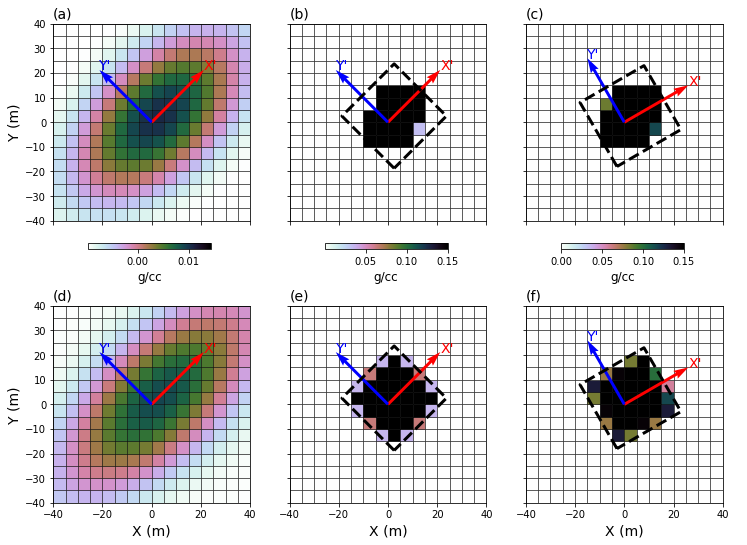

In [131]:
xlim = 40
midz = int(searchsorted(mesh.vectorCCz, -20))
vmax = mrec27pt[1].max()
vmin = mrec27pt[1].min()
fig = plt.figure(figsize=(12, 10))
square = np.c_[np.r_[-15,-15,15,15,-15],np.r_[-15,15,15,-15,-15]]
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(b)']
count = -1

def Rz(theta):
    """Rotation matrix about z axis"""
    Rz = np.vstack((np.r_[np.cos((theta)),
                          np.sin((theta))],
                   np.r_[-np.sin((theta)),
                         np.cos((theta))]))
    return Rz

for ii, ang in enumerate([45,45,30]):
        
    count += 1
    ax1 = plt.subplot(2,3,count+1)

    if count == 0:
        vmax = 0.01
    else:
        vmax = 0.15
        
    im2 = mesh.plotSlice(
        actvMap * mrec6pt[count], ind=midz, normal='Z', ax=ax1,
        pcolorOpts={"cmap":"cubehelix_r", "clim":[0, vmax], "vmax":vmax}, grid=True) 
#         cbar.set_label("$\kappa$", rotation=0, size=14)
    ax1.set_aspect('equal')
    ax1.set_xlim([-xlim, xlim])
    ax1.set_ylim([-xlim, xlim])
    ax1.set_xlabel('')
    ax1.set_ylabel('Y (m)', size=14)

    ax1.set_xlabel("")
    ax1.set_xticklabels([])

    if count not in [0]:

        ax1.set_ylabel("")
        ax1.set_yticklabels([])
#     ax1.add_patch(Rectangle(corners[0][::2],corners[1][0] - corners[0][0],corners[1][2] - corners[0][2], facecolor = 'none', edgecolor='r', linewidth=3))
#     ax1.grid(color='w', linestyle='--', linewidth=0.5)
    vrtx = np.dot(Rz(-np.deg2rad(ang)), square.T).T
    vrtx[:,1] += 2.5
    vrtx[:,0] += 2.5
    
    if count != 0:
        plt.plot(vrtx[:,0],vrtx[:,1], 'k--', linewidth=3)
    
    
    vecx = np.dot(Rz(-np.deg2rad(ang)), np.r_[30,0])
    vecy = np.dot(Rz(-np.deg2rad(ang)), np.r_[0,30])
    
    plt.quiver(0,0, vecx[0], vecx[1], angles='xy', scale_units='xy', scale=1., width=.015, color='r')
    plt.text(vecx[0],vecx[1], "X'", color='r', size=14, zorder=4)
    plt.quiver(0,0, vecy[0], vecy[1], angles='xy', scale_units='xy', scale=1., width=.015, color='b')
    plt.text(vecy[0],vecy[1], "Y'", color='b', size=14, zorder=4)
    loc = ax1.get_position()
    if count in [0]:
#         ax1.set_position([loc.x0, loc.y0, loc.width*1.0, loc.height*1.0])

        cbarAxis = plt.axes([loc.x0-0.025, loc.y0-0.04, loc.height, loc.width*0.25])
        cbarAxis.axis('off')
        cbar = plt.colorbar(im2[0], ax = cbarAxis,
                    format="%.2f", orientation='horizontal')
        cbar.set_ticks(np.linspace(0, mrec6pt[count].max(), 4))
        cbar.set_label("g/cc", size=12)
    
    else:
#         ax1.set_position([loc.x0, loc.y0, loc.width*1.0, loc.height*1.0])
        cbarAxis = plt.axes([loc.x0-0.025, loc.y0-.04, loc.height, loc.width*0.25])
        cbarAxis.axis('off')
        cbar = plt.colorbar(im2[0], ax = cbarAxis,
                    format="%.2f", orientation='horizontal')
#         cbar.set_ticks(np.linspace(mrec6pt[count].min(), mrec6pt[count].max(), 5))
        cbar.set_label("g/cc", size=12)
    ax1.grid(False)
    ax1.set_title(labels[count], loc='left', size=14)
#     Utils.PlotUtils.plotProfile(
#         xyzLoc, a, b, 21, fig=fig,
#         ax=ax1, coordinate_system='xProfile',
#         plotStr='k.'
#     )
#     Utils.PlotUtils.plotProfile(
#         topo, a, b, 21, fig=fig,
#         ax=ax1, coordinate_system='xProfile',
#     )
    # ax1.set_xlabel("")
    ax1.set_title("", loc='center', size=14)
    
    ax1 = plt.subplot(2,3,count+4)

    if count == 0:
        vmax = 0.0075
    else:
        vmax = 0.075
    im2 = mesh.plotSlice(
        actvMap * mrec27pt[count], ind=midz, normal='Z', ax=ax1,
        pcolorOpts={"cmap":"cubehelix_r", "clim":[0,vmax], "vmax":vmax}, grid=True) 
#         cbar.set_label("$\kappa$", rotation=0, size=14)
    ax1.set_aspect('equal')
    ax1.set_xlim([-xlim, xlim])
    ax1.set_ylim([-xlim, xlim])
    ax1.set_xlabel('X (m)', size=14)
    ax1.set_ylabel('Y (m)', size=14)
    plt.quiver(0,0, vecx[0], vecx[1], angles='xy', scale_units='xy', scale=1., width=.015, color='r')
    plt.text(vecx[0],vecx[1], "X'", color='r', size=14, zorder=4)
    plt.quiver(0,0, vecy[0], vecy[1], angles='xy', scale_units='xy', scale=1., width=.015, color='b')
    plt.text(vecy[0],vecy[1], "Y'", color='b', size=14, zorder=4)

    if count not in [0]:

        ax1.set_ylabel("")
        ax1.set_yticklabels([])
#     ax1.add_patch(Rectangle(corners[0][::2],corners[1][0] - corners[0][0],corners[1][2] - corners[0][2], facecolor = 'none', edgecolor='r', linewidth=3))
#     ax1.grid(color='w', linestyle='--', linewidth=0.5)
    vrtx = np.dot(Rz(-np.deg2rad(ang)), square.T).T
    vrtx[:,1] += 2.5
    vrtx[:,0] += 2.5
    if count != 0:
        plt.plot(vrtx[:,0],vrtx[:,1], 'k--', linewidth=3)
    loc = ax1.get_position()
#     if count in [1]:
    ax1.set_position([loc.x0, loc.y0+0.02, loc.width*1.0, loc.height*1.0])
#         loc = ax1.get_position()
#         cbarAxis = plt.axes([loc.x0+0.175, loc.y0+0.02, loc.height, loc.width*0.5])
#         cbarAxis.axis('off')
#         cbar = plt.colorbar(im2[0], ax = cbarAxis,
#                     format="%.2f", orientation='vertical')
#         cbar.set_ticks(np.linspace(0, mrec27pt[count].max(), 4))
#         cbar.set_label("g/cc", size=12)
    
#     else:
#         ax1.set_position([loc.x0, loc.y0, loc.width*1.0, loc.height*1.0])

    ax1.grid(False)
    ax1.set_title(labels[count+3], loc='left', size=14)
#     Utils.PlotUtils.plotProfile(
#         xyzLoc, a, b, 21, fig=fig,
#         ax=ax1, coordinate_system='xProfile',
#         plotStr='k.'
#     )
#     Utils.PlotUtils.plotProfile(
#         topo, a, b, 21, fig=fig,
#         ax=ax1, coordinate_system='xProfile',
#     )
    # ax1.set_xlabel("")
    ax1.set_title("", loc='center', size=14)
    
    
plt.savefig("Grav_Block_Rotation.png", bbox_inches='tight', dpi=300)

# Plot data residuals


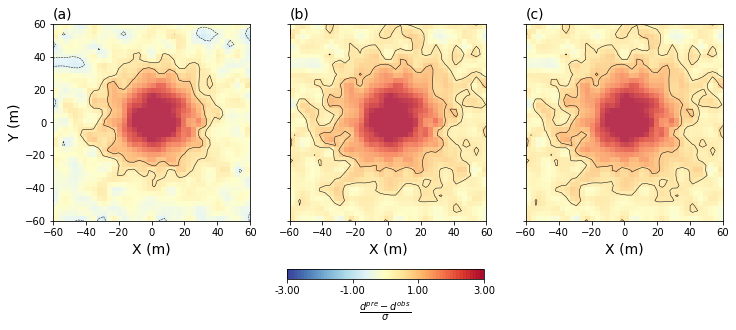

In [130]:
fig = plt.figure(figsize=(12, 8))
count = -1
for ii, ang in enumerate([45,45,30]):
        
    count += 1
    ax1 = plt.subplot(2,3,count+1)
    
    vmin, vmax = -3, 3
    X, Y, d_grid, im, CS = Simulator.plotDataHillside(
                            surveyGrav.srcField.rxList[0].locs[:,0],
                            surveyGrav.srcField.rxList[0].locs[:,1], 
                            (surveyGrav.dobs - probGrav.fields(mrec27pt[count]))/surveyGrav.std, 
                            distMax=200, minCurvature=False,
                              cmap='RdYlBu_r', resolution=3., axs=ax1, 
                                vmin=vmin, vmax=vmax, equalizeHist=False,
                              clabel=False, contours=np.r_[-1,-0.5,0.5,1],  
                              alpha=0.8, alphaHS=0, ve=1., azdeg=30, altdeg=30)


    # cbar.set_label("mGal", rotation=0, size=14)
    ax1.set_xlabel('X (m)', size=14)
    ax1.set_ylabel('Y (m)', size=14)
    ax1.set_aspect('equal')
    
    if count != 0:
        ax1.set_ylabel("")
        ax1.set_yticklabels([])
    ax1.set_title(labels[count], loc='left', size=14)

    pos = ax1.get_position()
    if count == 1:
        cbarAxis = plt.axes([pos.x0-.06, pos.y0-0.1, pos.height, pos.width*0.5])
        cbarAxis.axis('off')
        cbar = plt.colorbar(im, ax = cbarAxis, ticks=np.linspace(-3, 3, 4),
                    format="%.2f", orientation='horizontal')
        cbar.set_label("$\\frac{d^{pre}-d^{obs}}{\sigma}$", rotation=0, size=14)
        
plt.savefig("Grav_Block_Rotation_Residual.png", bbox_inches='tight', dpi=300)

In [123]:
vmin, vmax


(9.912260462092481e-05, 0.005017693307501696)

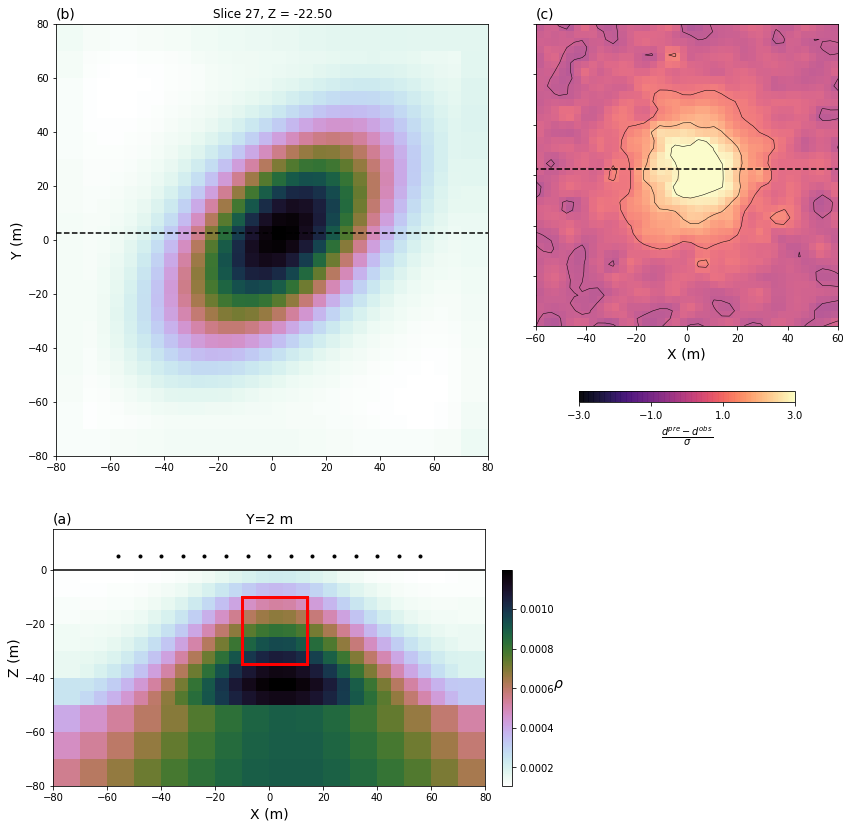

In [127]:
contours = [0.01]
xlim = 80.
midy = int(np.searchsorted(mesh.vectorCCy, 0))
fig = plt.figure(figsize=(8, 8))
ax3 = plt.axes([0.08, 0.5, 0.75, .75])

dpred = probGrav.fields(mrec6pt[0])
# profile coordinates
a = np.r_[-xlim, mesh.vectorCCy[midy]]
b = np.r_[xlim, mesh.vectorCCy[midy]]
# PF.Magnetics.plotModelSections(mesh, mrec_sus, normal='z', ind=-3, subFact=2, scale=0.25, xlim=[-xlim, xlim], ylim=[-xlim, xlim],
#                       title="Esus Model", axs=ax3, vmin=0, vmax=vmax, contours = contours)
# ax3.xaxis.set_visible(False)
vmin, vmax = mrec6pt[0].min(), mrec6pt[0].max
im1 = mesh.plotSlice(
    actvMap * mrec6pt[0], ind=int(np.searchsorted(mesh.vectorCCz, -25)), normal='Z', ax=ax3,
    pcolorOpts={"cmap":"cubehelix_r", "clim":[vmin,vmax]}) 
# cbar.set_label("$\kappa_e$", rotation=0, size=14)
ax3.set_aspect('equal')
ax3.set_xlabel("")
ax3.set_ylabel('Y (m)', size=14)
ax3.set_xlim([-xlim, xlim])
ax3.set_ylim([-xlim, xlim])
ax3.grid(False)

# ax3.set_xlabel("")
ax3.set_title("(b)", loc='left', size=14)
# ax3.set_xticks([])
pos = ax3.get_position()
ax3.set_position([pos.x0, pos.y0, pos.height, pos.width])
ax3.plot(np.r_[a[0], b[0]], np.r_[a[1], b[1]], 'k--')


ax3 = plt.axes([0.8, 0.5, 0.75, .75])
# vmin, vmax = -3,3
X, Y, d_grid, im, CS = Simulator.plotDataHillside(
                        surveyGrav.srcField.rxList[0].locs[:,0],
                        surveyGrav.srcField.rxList[0].locs[:,1], 
                        (surveyGrav.dobs-dpred)/surveyGrav.std , distMax=200, minCurvature=False,
                          cmap='magma', resolution=3., axs=ax3, 
                            vmin=-3, vmax=3, equalizeHist=False,
                          clabel=False, contours=[-3,-2,-1,0,1,2,3],  
                          alpha=0.8, alphaHS=0, ve=1., azdeg=30, altdeg=30)

cbar = plt.colorbar(im, ticks=np.linspace(-3,3, 4),
            format="${%.1f}$", shrink=0.5, orientation='horizontal')
cbar.set_label("$\\frac{d^{pre} - d^{obs}}{\sigma}$", rotation=0, size=14)
ax3.set_xlabel('X (m)', size=14)
ax3.set_ylabel('', size=14)
ax3.set_aspect('equal')
# ax3.set_xlabel("")
ax3.set_title("(c)", loc='left', size=14)
ax3.set_yticklabels([])
pos = ax3.get_position()
ax3.set_position([pos.x0, pos.y0, pos.height, pos.width])
ax3.plot(np.r_[a[0], b[0]], np.r_[a[1], b[1]], 'k--')

# Plot the model
ax2 = plt.axes([0.05, -0.25, 0.75, .75])
vmax = invProb.model.max()
vmin = invProb.model.min()
# im2 = mesh.plotSlice(
#     actvMap * sus, ind=midy, normal='Y', ax=ax2,
#     pcolorOpts={"cmap":"pink_r"}, grid=True) 

im1 = mesh.plotSlice(
    actvMap * mrec6pt[0], ind=int(np.searchsorted(mesh.vectorCCy, 0)), normal='Y', ax=ax2,
    pcolorOpts={"cmap":"cubehelix_r", "clim":[vmin,vmax]}) 
# cbar.set_label("$\kappa_e$", rotation=0, size=14)
ax2.set_aspect('equal')
ax2.set_xlim([-xlim, xlim])
ax2.set_ylim([-xlim, 15])
ax2.grid(False)

# plotVectorsOctree(mesh, mvec_true, 0, axs=ax2, scale=0.4, vec='w', resolution=10, normal='Y', actvMap=actvMap, zorder=4)
# for midx in locx:
ax2.add_patch(Rectangle(corners[0][::2],corners[1][0] - corners[0][0],corners[1][2] - corners[0][2], facecolor = 'none', edgecolor='r', linewidth=3))
# ax2.grid(color='w', linestyle='--', linewidth=0.5)
loc = ax2.get_position()
ax2.set_position([loc.x0+0.025, loc.y0+0.025, loc.width, loc.height])
ax2.set_xlabel('X (m)', size=14)
ax2.set_ylabel('Z (m)', size=14)
ax2.set_title("(a)", loc='left', size=14)
ax2.set_title("Y=%.0f" % mesh.vectorCCy[midy] + " m", loc='center', size=14)
Utils.PlotUtils.plotProfile(
    xyzLoc, a, b, 21, fig=fig,
    ax=ax2, coordinate_system='xProfile',
    plotStr='k.'

)
Utils.PlotUtils.plotProfile(
    topo, a, b, 21, fig=fig,
    ax=ax2, coordinate_system='xProfile',
)

pos = ax2.get_position()
cbarAxis = plt.axes([pos.x0+0.4, pos.y0, pos.height, pos.width*0.5])
cbarAxis.axis('off')
cbar = plt.colorbar(im1[0], ax = cbarAxis, #ticks=np.linspace(vmin, vmax, 4),
            format="%.4f", orientation='vertical')
cbar.set_label("$\\rho$", rotation=0, size=14)


# ax2.axis('off')
# cbarAxis = plt.axes([pos.x0+0.5, pos.y0, pos.height, pos.width*0.5])
# cbarAxis.axis('off')
# cbar = plt.colorbar(im1[0], ax = cbarAxis, ticks=np.linspace(0, den.max(), 5),
#             format="%.1f", orientation='vertical')
# cbar.set_ticklabels(["%.2f" % ii for ii in np.linspace(0, 0.2, 5).tolist()]
# )
# cbar.set_label("$\\rho$", rotation=0, size=14)
# "cubehelix_r"

plt.savefig("Grav_Inv_LiDWO_l2.png", bbox_inches='tight', dpi=300)

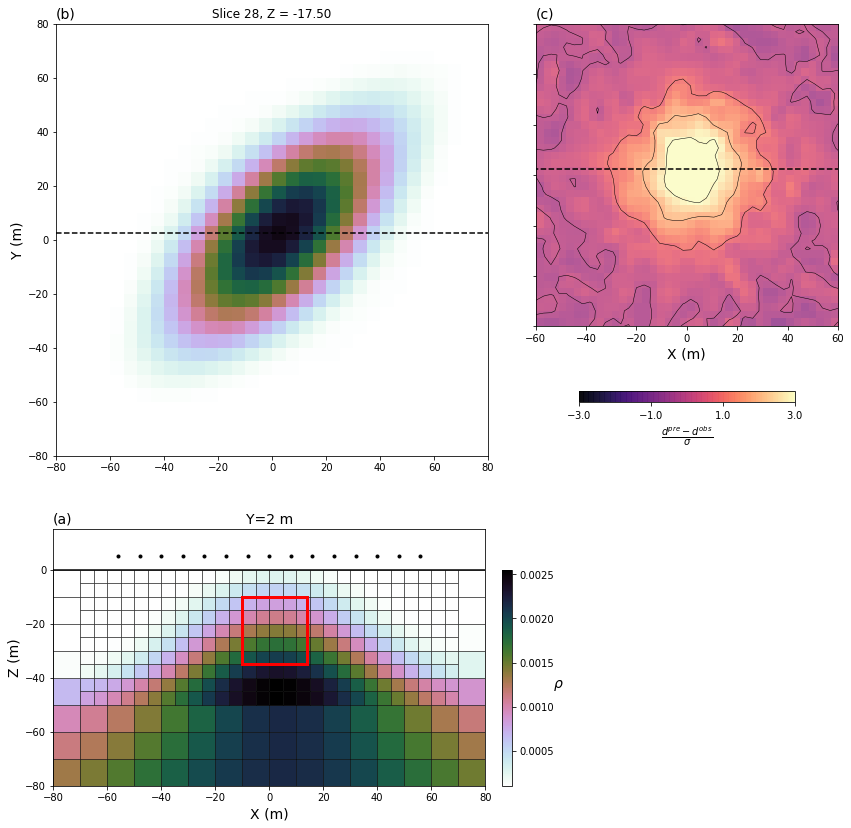

In [58]:
contours = [0.01]
xlim = 80.
midy = int(np.searchsorted(mesh.vectorCCy, 0))
fig = plt.figure(figsize=(8, 8))
ax3 = plt.axes([0.08, 0.5, 0.75, .75])

dpred = probGrav.fields(mrec27pt[0])
# profile coordinates
a = np.r_[-xlim, mesh.vectorCCy[midy]]
b = np.r_[xlim, mesh.vectorCCy[midy]]
# PF.Magnetics.plotModelSections(mesh, mrec_sus, normal='z', ind=-3, subFact=2, scale=0.25, xlim=[-xlim, xlim], ylim=[-xlim, xlim],
#                       title="Esus Model", axs=ax3, vmin=0, vmax=vmax, contours = contours)
# ax3.xaxis.set_visible(False)
vmin, vmax = mrec27pt[0].min(), mrec27pt[0].max
im1 = mesh.plotSlice(
    actvMap * mrec27pt[0], ind=int(np.searchsorted(mesh.vectorCCz, -20)), normal='Z', ax=ax3,
    pcolorOpts={"cmap":"cubehelix_r", "clim":[vmin,vmax]}) 
# cbar.set_label("$\kappa_e$", rotation=0, size=14)
ax3.set_aspect('equal')
ax3.set_xlabel("")
ax3.set_ylabel('Y (m)', size=14)
ax3.set_xlim([-xlim, xlim])
ax3.set_ylim([-xlim, xlim])
ax3.grid(False)

# ax3.set_xlabel("")
ax3.set_title("(b)", loc='left', size=14)
# ax3.set_xticks([])
pos = ax3.get_position()
ax3.set_position([pos.x0, pos.y0, pos.height, pos.width])
ax3.plot(np.r_[a[0], b[0]], np.r_[a[1], b[1]], 'k--')


ax3 = plt.axes([0.8, 0.5, 0.75, .75])
# vmin, vmax = -3,3
X, Y, d_grid, im, CS = Simulator.plotDataHillside(
                        surveyGrav.srcField.rxList[0].locs[:,0],
                        surveyGrav.srcField.rxList[0].locs[:,1], 
                        (surveyGrav.dobs-dpred)/surveyGrav.std , distMax=200, minCurvature=False,
                          cmap='magma', resolution=3., axs=ax3, 
                            vmin=-3, vmax=3, equalizeHist=False,
                          clabel=False, contours=[-3,-2,-1,0,1,2,3],  
                          alpha=0.8, alphaHS=0, ve=1., azdeg=30, altdeg=30)

cbar = plt.colorbar(im, ticks=np.linspace(-3,3, 4),
            format="${%.1f}$", shrink=0.5, orientation='horizontal')
cbar.set_label("$\\frac{d^{pre} - d^{obs}}{\sigma}$", rotation=0, size=14)
ax3.set_xlabel('X (m)', size=14)
ax3.set_ylabel('', size=14)
ax3.set_aspect('equal')
# ax3.set_xlabel("")
ax3.set_title("(c)", loc='left', size=14)
ax3.set_yticklabels([])
pos = ax3.get_position()
ax3.set_position([pos.x0, pos.y0, pos.height, pos.width])
ax3.plot(np.r_[a[0], b[0]], np.r_[a[1], b[1]], 'k--')

# Plot the model
ax2 = plt.axes([0.05, -0.25, 0.75, .75])
vmax = invProb.model.max()
vmin = invProb.model.min()
# im2 = mesh.plotSlice(
#     actvMap * sus, ind=midy, normal='Y', ax=ax2,
#     pcolorOpts={"cmap":"pink_r"}, grid=True) 

im1 = mesh.plotSlice(
    actvMap * mrec27pt[0], ind=int(np.searchsorted(mesh.vectorCCy, 0)), normal='Y', ax=ax2,
    pcolorOpts={"cmap":"cubehelix_r", "clim":[vmin,vmax]}, grid=True) 
# cbar.set_label("$\kappa_e$", rotation=0, size=14)
ax2.set_aspect('equal')
ax2.set_xlim([-xlim, xlim])
ax2.set_ylim([-xlim, 15])
ax2.grid(False)

# plotVectorsOctree(mesh, mvec_true, 0, axs=ax2, scale=0.4, vec='w', resolution=10, normal='Y', actvMap=actvMap, zorder=4)
# for midx in locx:
ax2.add_patch(Rectangle(corners[0][::2],corners[1][0] - corners[0][0],corners[1][2] - corners[0][2], facecolor = 'none', edgecolor='r', linewidth=3))
# ax2.grid(color='w', linestyle='--', linewidth=0.5)
loc = ax2.get_position()
ax2.set_position([loc.x0+0.025, loc.y0+0.025, loc.width, loc.height])
ax2.set_xlabel('X (m)', size=14)
ax2.set_ylabel('Z (m)', size=14)
ax2.set_title("(a)", loc='left', size=14)
ax2.set_title("Y=%.0f" % mesh.vectorCCy[midy] + " m", loc='center', size=14)
Utils.PlotUtils.plotProfile(
    xyzLoc, a, b, 21, fig=fig,
    ax=ax2, coordinate_system='xProfile',
    plotStr='k.'

)
Utils.PlotUtils.plotProfile(
    topo, a, b, 21, fig=fig,
    ax=ax2, coordinate_system='xProfile',
)

pos = ax2.get_position()
cbarAxis = plt.axes([pos.x0+0.4, pos.y0, pos.height, pos.width*0.5])
cbarAxis.axis('off')
cbar = plt.colorbar(im1[0], ax = cbarAxis, #ticks=np.linspace(vmin, vmax, 4),
            format="%.4f", orientation='vertical')
cbar.set_label("$\\rho$", rotation=0, size=14)


# ax2.axis('off')
# cbarAxis = plt.axes([pos.x0+0.5, pos.y0, pos.height, pos.width*0.5])
# cbarAxis.axis('off')
# cbar = plt.colorbar(im1[0], ax = cbarAxis, ticks=np.linspace(0, den.max(), 5),
#             format="%.1f", orientation='vertical')
# cbar.set_ticklabels(["%.2f" % ii for ii in np.linspace(0, 0.2, 5).tolist()]
# )
# cbar.set_label("$\\rho$", rotation=0, size=14)
# "cubehelix_r"

plt.savefig("Grav_Inv_7pt_l2.png", bbox_inches='tight', dpi=300)

# Mesh decoupling figures

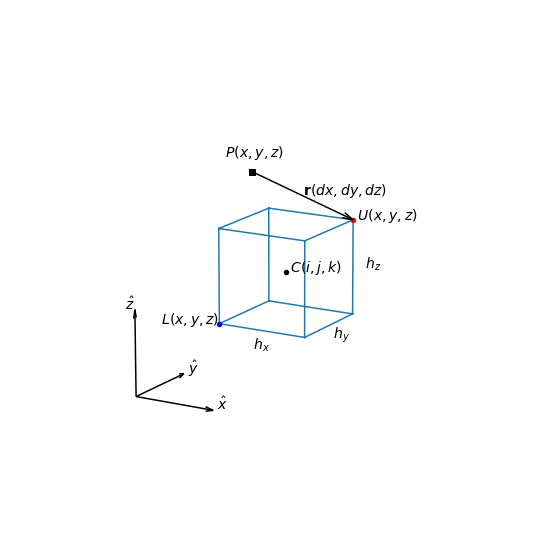

In [142]:
# Create figure for discretization
plt.figure(figsize=(10,10))
axs = plt.subplot(projection='3d')
mesh1 = Mesh.TensorMesh([1,1,1])
mesh1.plotGrid(ax=axs)
axs.scatter(0.5,0.5,0.5, c='k')
axs.text(0.5,0.5,0.5, ' $C(i,j,k)$', ha='left', size=14)


# Obs point
axs.scatter(0.5,0.1,1.5, c='k', marker='s', s=30, facecolor='w')
axs.text(0.5,0.1,1.6,' $P(x,y,z)$', va='bottom', ha='center', size=14)
axs.quiver(
    0.5,0.1,1.5, -0.5,0.9,-0.5, colors='k',
    arrow_length_ratio=0.1
    
)
axs.text(0.25,0.5,1.25,' $\mathbf{r}(dx,dy,dz)$', ha='left', size=14)



axs.text(0,1,1, ' $U(x,y,z)$', ha='left', size=14)
axs.scatter(0,1,1, c='r')

axs.text(1,0,0, ' $L(x,y,z)$', ha='right', size=14)
axs.scatter(1,0,0, c='b')

axs.text(1.25,0.75,-.1, ' $h_x$', ha='right', size=14)
axs.text(0.5,1.25,-.1, ' $h_y$', ha='right', size=14)
axs.text(0.0,1.1,.5, ' $h_z$', ha='left', size=14)

axs.set_xlim([-1,2])
axs.set_ylim([-1,2])
axs.set_zlim([-1,2])
axs.set_aspect('equal')



axs.quiver(
    -0.5,-2,-1.5, -1,0,0, colors='k',
    arrow_length_ratio=0.1, zorder=0
    
)
axs.text(-1.5,-2,-1.5, ' $\hat y$', ha='left', size=14)

axs.quiver(
    -0.5,-2,-1.5, 0,1,0, colors='k',
    arrow_length_ratio=0.1, zorder=0
    
)
axs.text(-0.5,-1,-1.5, ' $\hat x$', ha='left', size=14)

axs.quiver(
    -0.5,-2,-1.5, 0,0,1, colors='k',
    arrow_length_ratio=0.1, zorder=0
    
)
axs.text(-0.5,-2,-.5, ' $\hat z$', ha='right', size=14)

axs.axis('off')
axs.view_init(elev=15., azim=30)
plt.savefig("PF_UnitCube.png", bbox_inches='tight', dpi=300)


In [220]:
int(np.searchsorted(mesh_t.vectorCCz, 0))


32

# Test tiling forward


In [251]:
mesh.nC, denRandom.shape, actv.sum()





(15292, (15292,), 12420)

In [7]:
# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, 0)

# Generate random model, random data
# denRandom = np.random.randn(mesh.nC)[actv]
denRandom = np.zeros(mesh.nC)
denRandom = actvMap*den

sphere = Utils.ModelBuilder.getIndicesSphere([200,200,-200], 300, mesh.gridCC)
denRandom[sphere] = 0.05

sphere = Utils.ModelBuilder.getIndicesSphere([200,-200,-200], 300, mesh.gridCC)
denRandom[sphere] = 0.025

denRandom = denRandom[actv]

d_gRandom = probGrav.fields(denRandom)


# # Create reduced identity map
# idenMap = Maps.IdentityMap(nP=3*nC)

# # Create the forward probMaglem (forwardOnly)
# probMag = PF.Magnetics.MagneticIntegral(mesh, chiMap=idenMap, actInd=actv,
#                                      verbose=False, forwardOnly=True,modelType='vector' )

# # Pair the surveyMag and probMaglem and compute data
# surveyMag.unpair()
# surveyMag.pair(probMag)
# nD = surveyMag.nD
# d_TMI = probMag.fields(mvec_true)


# # Add noise and uncertainties
# # We add some random Gaussian noise (1nT)
# noise = np.random.randn(nD)
# d_TMI += noise
# wd = np.ones(len(d_TMI))*1.  # Assign flat uncertainties
# surveyMag.dobs = d_TMI

Dask:
n_cpu:  8
n_chunks:  1
Chunk sizes:  441 12420
RAM/tile:  0.35054208000000003
Total RAM (x n_cpu):  2.8043366400000003
[########################################] | 100% Completed |  3.1s


# Test a range of tile numbers


In [8]:

phid = []
probSize = []

octree_levels_padding = [8,4]
# octree_levels_obs = [10,4]
# octree_levels_topo = [0,2] 

def createLocalProb(rxLoc, wrGlobal, lims, ind):
    # createLocalProb(rxLoc, wrGlobal, lims, ind)
    # Generate a problem, calculate/store sensitivities for
    # given data points

    # Grab the data for current tile
    ind_t = np.all([rxLoc[:, 0] >= lims[0], rxLoc[:, 0] <= lims[1],
                    rxLoc[:, 1] >= lims[2], rxLoc[:, 1] <= lims[3],
                    surveyMask], axis=0)

    # Remember selected data in case of tile overlap
    surveyMask[ind_t] = False
    rxLoc_t = PF.BaseGrav.RxObs(rxLoc[ind_t, :])
    srcField = PF.BaseGrav.SrcField([rxLoc_t])
    survey_t = PF.BaseGrav.LinearSurvey(srcField)
    survey_t.dobs = surveyGrav.dobs[ind_t]
    survey_t.std = surveyGrav.std[ind_t]
    survey_t.ind = ind_t
    
    meshLocal = meshutils.mesh_builder_xyz(
        topo, core_cell_size, padding_distance=padding_distance, mesh_type='TREE'
    )
    if topo is not None:
        meshLocal = meshutils.refine_tree_xyz(
            meshLocal, topo, method='surface',
            octree_levels=octree_levels_topo, finalize=False
        )

    meshLocal = meshutils.refine_tree_xyz(
        meshLocal, rxLoc[ind_t, :], method='surface',
        octree_levels=octree_levels_obs,
        octree_levels_padding=octree_levels_padding,
        finalize=True,
    )
    
    # Need to find a way to compute sensitivities only for intersecting cells
    activeCells_t = np.ones(meshLocal.nC, dtype='bool')  # meshUtils.modelutils.activeTopoLayer(meshLocal, topo)
    tileMap = Maps.Tile((mesh, actv), (meshLocal, activeCells_t), nBlock=1)

    activeCells_t = tileMap.activeLocal
    prob = PF.Gravity.GravityIntegral(
            meshLocal, rhoMap=tileMap, actInd=activeCells_t,
            Jpath="Tile" + str(ind) + ".zarr",
            )
    
    survey_t.pair(prob)
    
    # Force calculation of J
    jtj = prob.getJtJdiag(np.ones(int(actv.sum())))
    
    dmis = DataMisfit.l2_DataMisfit(survey_t)
    
    
    
    
    return dmis

for tt in range(6):

    tiles, binCount, label, tile_number = Utils.modelutils.tileSurveyPoints(
        surveyGrav.rxLoc, tt-1, method='linear')

    X1, Y1 = tiles[0][:, 0], tiles[0][:, 1]
    X2, Y2 = tiles[1][:, 0], tiles[1][:, 1]

    nTiles = X1.shape[0]

    idenMap = Maps.IdentityMap(nP=nC)
    wrGlobal = np.zeros(nC)

    rxLoc = surveyGrav.rxLoc
    surveyMask = np.ones(surveyGrav.nD, dtype='bool')

    nParam = 0
    
    tc = time.time()
    # Loop through the tiles and generate all sensitivities
    for tile in range(nTiles):

        print("Tile " + str(tile+1) + " of " + str(X1.shape[0]))

        dmis = createLocalProb(rxLoc, wrGlobal, np.r_[X1[tile], X2[tile], Y1[tile], Y2[tile]], tile)

        nParam += dmis.prob.rhoMap.shape[0] * dmis.prob.survey.nD * 8 *1e-6
        # Add the problems to a Combo Objective function
        if tile == 0:
            ComboMisfit = dmis

        else:
            ComboMisfit += dmis

    
    dpred = np.zeros(surveyGrav.nD)
    
    if nTiles > 1:
        for ind, dmis in enumerate(ComboMisfit.objfcts):
            dpred[dmis.survey.ind] += dmis.survey.dpred(denRandom).compute()
    else:
        print("Single tile")
        dpred = dmis.survey.dpred(denRandom).compute()
        
    probSize += [np.c_[nTiles, nParam, time.time()-tc]]    
    phid += [np.linalg.norm(dpred-d_gRandom)]
    
    

Tile 1 of 1
Dask:
n_cpu:  8
n_chunks:  1
Chunk sizes:  441 17992
RAM/tile:  0.507806208
Total RAM (x n_cpu):  4.062449664
Saving G to zarr: Tile0.zarr
[########################################] | 100% Completed |  4.0s
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Single tile
2 1
Tile 1 of 2
Dask:
n_cpu:  8
n_chunks:  1
Chunk sizes:  231 12532
RAM/tile:  0.185273088
Total RAM (x n_cpu):  1.482184704
Zarr file detected with wrong shape and chunksize ... over-writting
Saving G to zarr: Tile0.zarr
[########################################] | 100% Completed |  1.7s
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Tile 2 of 2
Dask:
n_cpu:  8
n_chunks:  1
Chunk sizes:  210 12532
RAM/tile:  0.16843008
Total RAM (x n_cpu):  1.34744064
Saving G to zarr: Tile1.zarr
[########################################] | 100% Completed |  1.8s
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
2 1
2 2
Tile 1 of 4
Dask:
n_cpu:  8
n_chun

([array([[-60., -60.],
         [-60.,   0.],
         [  0., -60.],
         [  0.,   0.]]), array([[ 0.,  0.],
         [ 0., 60.],
         [60.,  0.],
         [60., 60.]])], 0)

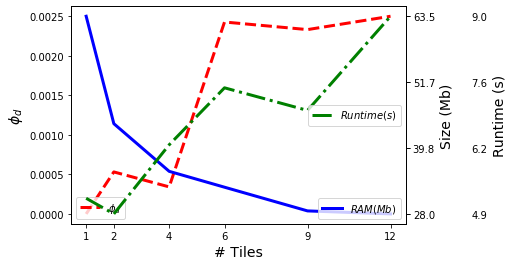

In [12]:
phid = np.vstack(phid)
probSize = np.vstack(probSize)
fig = plt.figure()

ax1 = plt.subplot()
ax1.plot(probSize[:,0], phid, 'r--', lw=3)
ax1.set_ylabel("$\\phi_d$", size=14)
# axs.legend(['RAM'], loc='upper left')
ax1.legend(['$\\phi_d$'], loc='lower left')
ax1.set_xlabel("# Tiles", size=14)
ax1.set_xticks(probSize[:,0])

axs = ax1.twinx()
axs.plot(probSize[:,0], probSize[:,1], 'b', lw=3)
axs.legend(['$RAM (Mb)$'], loc='lower right')
axs.set_ylabel("Size (Mb)", size=14)
axs.set_yticks(np.linspace(probSize[:,1].min(), probSize[:,1].max(), 4))
axs.set_yticklabels(["%.1f" % nn for nn in np.linspace(probSize[:,1].min(), probSize[:,1].max(), 4).tolist()])

loc = axs.get_position()
ax2 = plt.axes(loc)
ax2.plot(probSize[:,0], probSize[:,2], 'g-.', lw=3)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.patch.set_alpha(0)
ax2.legend(['$Runtime (s)$'], loc='center right')
ax2.set_ylabel('Runtime (s)', size=14)
ax2.set_yticks(np.linspace(probSize[:,2].min(), probSize[:,2].max(), 4))
ax2.set_yticklabels(["%.1f" % nn for nn in np.linspace(probSize[:,2].min(), probSize[:,2].max(), 4).tolist()])
ax2.yaxis.labelpad = 5
# ax2.set_yticklabels(probSize[:,2])
ax2.set_xticks([])

labels = ax2.get_yticklabels()
for i, label in enumerate(labels):
    label.set_x(label.get_position()[0] + 0.175)
    
plt.savefig("Tiled_Test_Size.png", bbox_inches='tight', dpi=300)

In [21]:
im



(<matplotlib.cm.ScalarMappable at 0x29fec9c0ba8>,)

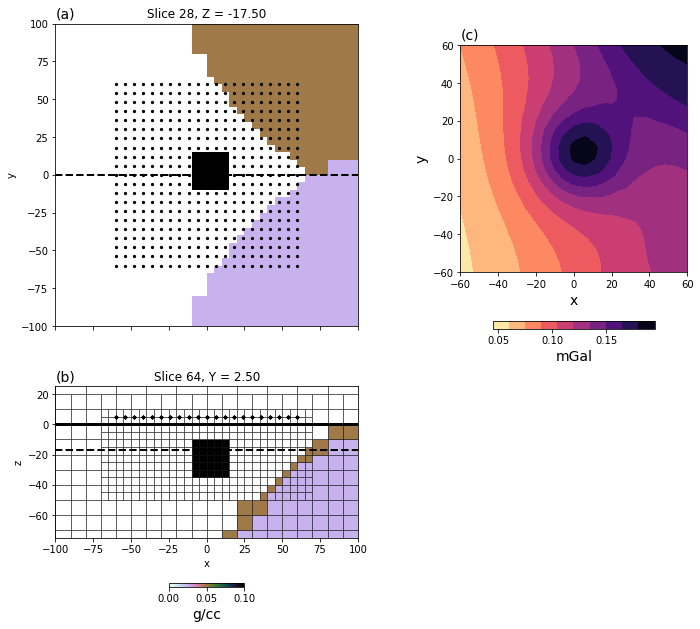

In [98]:

from matplotlib.patches import Rectangle

# fig, axs = plt.figure, plt.subplot(projection='3d')
fig = plt.figure(figsize=(12,6))
# Utils.plot2Ddata(xyzLoc, np.ones(xyzLoc.shape[0]), ax=axs)
# Tile the problem
# tiles, binCount, label, tileID = Utils.modelutils.tileSurveyPoints(xyzLoc, 0, method='linear')

# # Grab the smallest bin and generate a temporary mesh
# indMin = np.argmin(binCount)
# X1, Y1 = tiles[0][:, 0], tiles[0][:, 1]
# X2, Y2 = tiles[1][:, 0], tiles[1][:, 1]

nTiles = X1.shape[0]
ax0 = axes([0, 0.7, 0.7, 0.7])
im = mesh.plotSlice(actvMap * denRandom, ax=ax0, 
               ind=int(np.searchsorted(mesh.vectorCCz, -20)), 
               pcolorOpts={"cmap":'cubehelix_r', "vmax":0.1},
               grid=False)

ax0.scatter(surveyGrav.rxLoc[:, 0], surveyGrav.rxLoc[:, 1], 5, color='k')
ax0.plot([-100,100], [0,0], 'k--', linewidth=2)
ax0.set_aspect('equal')
ax0.set_xticklabels([])
ax0.set_xlim([-100, 100])
ax0.set_ylim([-100, 100])
ax0.set_xlabel("")
ax0.set_title("(a)", size=14, loc='left')

loc = ax0.get_position()
ax1 = axes([loc.x0, loc.y0-0.7, loc.width, loc.height])
im = mesh.plotSlice(actvMap * denRandom, ax=ax1,normal='Y',
               ind=int(np.searchsorted(mesh.vectorCCy, 0)), 
               pcolorOpts={"cmap":'cubehelix_r', "vmax":0.1},
               grid=True)
ax1.scatter(surveyGrav.rxLoc[:, 1], surveyGrav.rxLoc[:, 2], 5, color='k')
ax1.set_ylim([-75, 25])
ax1.set_xlim([-100, 100])
ax1.plot([-100,100], [-17,-17], 'k--', linewidth=2)
ax1.plot([-100,100], [0,0], 'k', linewidth=3)
cbar = plt.colorbar(im[0], orientation='horizontal', shrink=0.25)
ax1.set_title("(b)", size=14, loc='left')
cbar.set_label("g/cc", size=14)
ax1.set_aspect('equal')

ax2 = axes([0.4, 0.6, 0.75, 0.75])
aa = Utils.plot2Ddata(surveyGrav.rxLoc, d_gRandom, ax = ax2, contourOpts={"cmap":"magma_r"})
ax2.set_title("(c)", size=14, loc='left')
ax2.set_ylabel("y", size=14)
ax2.set_xlabel("x", size=14)
cbar = plt.colorbar(aa[0], orientation='horizontal', ticks=np.linspace(0,0.2,5), shrink=0.25)

cbar.set_label("mGal", size=14)

plt.savefig("Tiled_Test_model.png", bbox_inches='tight', dpi=300)



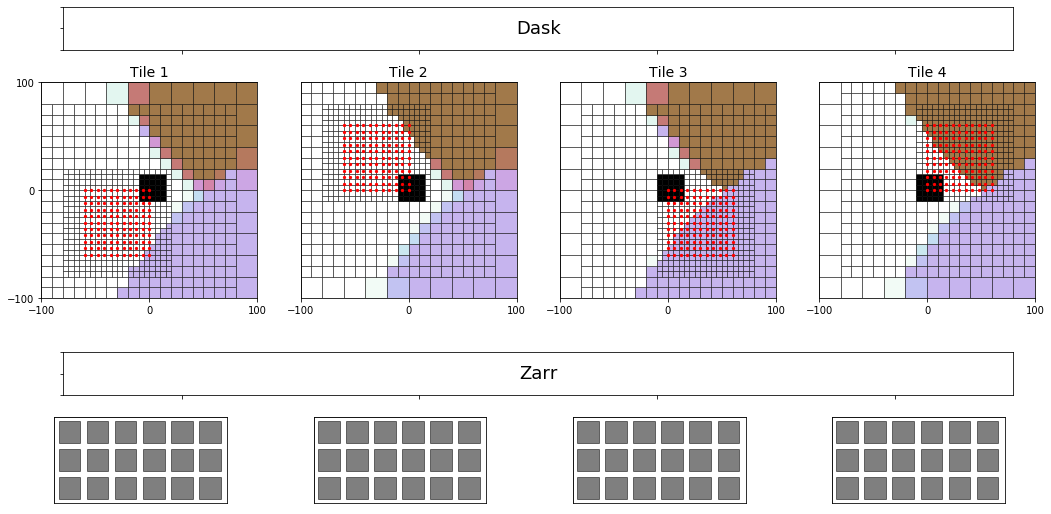

In [124]:
fig = plt.figure(figsize=(12,6))
axs = axes([0., 0.4, 1.1, 0.1])
axs.set_xlim([0,1])
axs.set_ylim([0,1])
axs.set_xticks(np.arange(0.125,1.,0.25))
axs.set_yticklabels([])
axs.set_xticklabels([])
axs.text(0.5,0.5, 'Dask', va='center', ha="center", size=18)

loc = axs.get_position()

axs = axes([loc.x0, loc.y0-0.8, loc.width, loc.height])
axs.set_xlim([0,1])
axs.set_ylim([0,1])
axs.set_xticks(np.arange(0.125,1.,0.25))
axs.set_yticklabels([])
axs.set_xticklabels([])
axs.text(0.5,0.5, 'Zarr', va='center', ha="center", size=18)



for tt in range(4):

    ind_t = np.all([xyzLoc[:, 0] >= X1[tt], xyzLoc[:, 0] <= X2[tt],
                    xyzLoc[:, 1] >= Y1[tt], xyzLoc[:, 1] <= Y2[tt]], 
                   axis=0)
    
#     ax0.add_patch(Rectangle((X1[tt], Y1[tt]),
#                                 X2[tt]-X1[tt],
#                                 Y2[tt]-Y1[tt],
#                                 facecolor='none', edgecolor='w', linewidth=3))
    
#     axs.plot(np.c_[X1[tt], Y1[tt], 0], np.c_[X2[tt], Y2[tt], 0], c='k')
    
    mesh_t = meshutils.mesh_builder_xyz(
    topo, [dx, dx, dx], padding_distance=[[50, 50], [50, 50], [50, 50]], mesh_type='TREE')
#     mesh_t.x0 = [-315, -312.5, -340]

#     mesh_t = meshutils.refineTreeXYZ(mesh_t, topo, octreeLevels=[0,2], octreeLevels_XY=[0,0], method='surface', finalize=False)
    ax1 = axes([loc.x0+0.3*tt-0.15, -0.175,0.5,0.5])
    mesh_t = meshutils.refine_tree_xyz(mesh_t, xyzLoc[ind_t,:], octree_levels=[10,4], method='surface', finalize=True)
    ax1.scatter(surveyGrav.rxLoc[ind_t, 0], surveyGrav.rxLoc[ind_t, 1], 5, color='k')
#     plt.scatter(xyzLoc[ind_t, 0], xyzLoc[ind_t, 1],tt)
    tileProb = ComboMisfit.objfcts[tt].prob

    actvTile = Maps.InjectActiveCells(tileProb.mesh, tileProb.actInd, np.nan)

    tileProb.mesh.plotSlice(actvTile*(tileProb.rhoMap.P*denRandom), 
                            pcolorOpts={"cmap":'cubehelix_r', "vmax":0.1}, ind=25, grid=True, ax=ax1)
    ax1.scatter(surveyGrav.rxLoc[ind_t, 0], surveyGrav.rxLoc[ind_t, 1], 5, color='r')
#     ax1.scatter(surveyGrav.rxLoc[ind_t==0, 0], surveyGrav.rxLoc[ind_t==0, 1], 5, color='b')
    ax1.set_xlim([-100, 100])
    ax1.set_ylim([-100, 100])
    
    ax1.set_aspect('equal')
    ax1.set_xticks([-100,0,100])
    if tt==0:
        ax1.set_yticks([-100,0,100])
    else:
        ax1.set_yticks([])
    ax1.set_title("Tile %i" %(tt+1), size=14)
    ax1.set_ylabel("")
    ax1.set_xlabel("")
    
    
    ax2 = axes([loc.x0+0.3*tt-0.11, -0.65, 0.4, 0.2])
    ax2.add_patch(Rectangle((0, 0),
                               4, 1,
                                facecolor='w', edgecolor='k', alpha=0.5, linewidth=1))
    
    for ii in range(6):
        for jj in range(3):
            
            ax2.add_patch(Rectangle((0.05+ii*0.325, 0.05+jj*0.325),
                           0.25, 0.25,
                            facecolor='k', alpha=0.5, edgecolor='k', linewidth=1))
    ax2.set_xlim([0,2])
    ax2.set_ylim([0,1])
    ax2.set_yticks([])
    ax2.set_ylabel("")
    ax2.set_xticks([])
    ax2.set_xlabel("")
    ax2.set_aspect('equal')

plt.savefig("Tiled_Dask.png", bbox_inches='tight', dpi=300)

In [ ]:
fig = plt.figure(figsize = (12, 6))



ax2 = plt.subplot(1,3,1)
aa = Utils.plot2Ddata(surveyGrav.rxLoc, d_gRandom, ax = ax2, contourOpts={"cmap":"magma_r"})
ax2.set_title("(a)", size=14, loc='left')
ax2.set_ylabel("y")
ax2.set_xlabel("x")
cbar = plt.colorbar(aa[0], orientation='horizontal', ticks=np.linspace(0,0.2,5))
cbar.set_label("mGal", size=14)


ax1 = plt.subplot(1,3,2)
aa = Utils.plot2Ddata(surveyGrav.rxLoc, dpred, ax = ax1, contourOpts={"cmap":"magma_r"})
ax1.set_title("(b)", size=14, loc='left')
ax1.set_xlabel("x")
cbar = plt.colorbar(aa[0], orientation='horizontal', ticks=np.linspace(0,0.2,5))
cbar.set_label("mGal", size=14)

ax1 = plt.subplot(1,3,3)
aa =Utils.plot2Ddata(surveyGrav.rxLoc, np.abs(dpred-d_gRandom)/dpred*100, ax = ax1, contourOpts={"cmap":"magma_r"})

ax1.set_title("(c)", size=14, loc='left')
ax1.set_xlabel("x")
cbar = plt.colorbar(aa[0], orientation='horizontal')
cbar.set_label("$\\frac{|d-d^{local}|}{|d|}\\times 100$", size=14)


plt.savefig("Forward_Tiles.png", bbox_inches='tight', dpi=300)


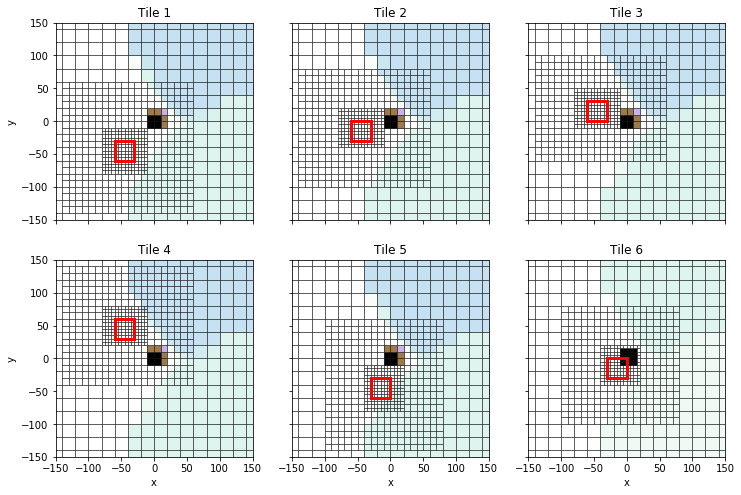

In [14]:
fig = plt.figure(figsize=(12,8))

for ii, misfit in enumerate(ComboMisfit.objfcts[:6]):
    
    axs = plt.subplot(2,3,ii+1)
    tileProb = misfit.prob

    actvTile = Maps.InjectActiveCells(tileProb.mesh, tileProb.actInd, np.nan)

    tileProb.mesh.plotSlice(actvTile*(tileProb.rhoMap.P*denRandom), pcolorOpts={"cmap":'cubehelix_r'}, ind=25, grid=True, ax=axs)
    
    
    axs.add_patch(Rectangle((X1[ii], Y1[ii]),
                                X2[ii]-X1[ii],
                                Y2[ii]-Y1[ii],
                                facecolor='none', edgecolor='r', linewidth=3))
    
#     axs.add_patch(Rectangle((X1[ii]-core_cell_size[0]*2, Y1[ii]-core_cell_size[0]*2),
#                                 X2[ii]-X1[ii]+core_cell_size[0]*4,
#                                 Y2[ii]-Y1[ii]+core_cell_size[0]*4,
#                                 facecolor='none', edgecolor='b', linewidth=2))
    
#     axs.add_patch(Rectangle((X1[ii]-core_cell_size[0]*8, Y1[ii]-core_cell_size[0]*12),
#                                 X2[ii]-X1[ii]+core_cell_size[0]*16,
#                                 Y2[ii]-Y1[ii]+core_cell_size[0]*24,
#                                 facecolor='none', edgecolor='g', linewidth=2))
    
    
    if ii in [1,2,4,5]:
        axs.set_ylabel("")
        axs.set_yticklabels([])
        
    if ii in [0,1,2]:
        axs.set_xlabel("")
        axs.set_xticklabels([])
    axs.set_xlim([-150, 150])
    axs.set_ylim([-150, 150])
    axs.set_title("Tile "+str(ii+1))
    
    axs.set_aspect('equal')
    



plt.savefig("Grav_Tiles.png", bbox_inches='tight', dpi=300)



# Test discretization with finite difference


In [91]:
reg_Simple.objfcts[1].epsilon



0.004635395317147805

In [191]:
padding_distance = [[50, 50], [50, 50], [200, 50]]

# Create a mesh
dx = 5#2.5#
core_cell_size = [dx, dx, dx]
octree_levels_padding = [1,3]
octree_levels_obs = [5,4]#[20,8]#
octree_levels_topo = [0,2] 

mesh = meshutils.mesh_builder_xyz(
    topo, core_cell_size, padding_distance=padding_distance,
    base_mesh=None,
    mesh_type='TREE',
)
# mesh.x0 = [-315, -312.5, -340]
mesh = meshutils.refine_tree_xyz(mesh, topo, octree_levels=octree_levels_topo, octree_levels_padding=[0,0], method='surface', finalize=False)
mesh = meshutils.refine_tree_xyz(mesh, xyzLoc, octree_levels=octree_levels_obs, octree_levels_padding=octree_levels_padding, method='surface', finalize=True)

actv = Utils.surface2ind_topo(mesh, topo, 'CC')

# Create active map to go from reduce space to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)
nC = int(actv.sum())

# Create reduced identity map
idenMap = Maps.IdentityMap(nP=nC)

# Create the forward probGravlem
probGrav = PF.Gravity.GravityIntegral(mesh, rhoMap=idenMap, actInd=actv,
                                     Jpath='.\\sensGrav.zarr', 
                                      verbose=False, parallelized='dask')

# Pair the surveyMag and probMaglem and compute data
surveyGrav.unpair()
surveyGrav.pair(probGrav)

# Create a regularization function, in this case l2l2
wr = probGrav.getJtJdiag(np.ones(nC))**0.5
wr = (wr/np.max(wr))

# Create a regularization
reg_Simple = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap, gradientType='component')
reg_Simple.cell_weights = wr 
for ii, objfct in enumerate(reg_Simple.objfcts[1:]):
    objfct.cell_weights /= mesh.h_gridded[actv, ii]**2.

reg_Simple.alpha_s = 1
reg_Simple.alpha_x = mesh.hx.min()**2.
reg_Simple.alpha_y = mesh.hy.min()**2.
reg_Simple.alpha_z = mesh.hz.min()**2.
reg_Simple.mref = np.zeros(nC)
# reg_Simple.eps_q = 1e-2
reg_Simple.norms = np.c_[1, 1, 1, 1]

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(surveyGrav)
dmis.W = 1./surveyGrav.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=100, lower=-1., upper=1.,
                                 maxIterLS=20, maxIterCG=20, tolCG=1e-3)
invProb = InvProblem.BaseInvProblem(dmis, reg_Simple, opt)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e+0)

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, betaSearch=False, maxIRLSiter=20, chifact_target=2., chifact_start=2.)
update_Jacobi = Directives.UpdatePreconditioner()
inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, IRLS, update_Jacobi])

# Run the inversion
m0 = np.ones(nC)*1e-4  # Starting model
mrec_den_l2 = inv.run(m0)




Dask:
n_cpu:  8
n_chunks:  8
Chunk sizes:  56 919
RAM/chunk:  0.000411712
Total RAM (x n_cpu):  0.003293696
Zarr file detected with wrong shape and chunksize ... over-writting
Saving G to zarr: .\sensGrav.zarr
[########################################] | 100% Completed |  6.9s
Use Simple
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
1.0 1.0
1.0 1.0
1.0 1.0
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.20e+06  5.94e+03  1.03e-06  5.94e+03    8.57e+01      0              
Start CG solve
CG solve time: 3.7130002975463867
   1  6.02e+05  3.13e+03  6.71e-04  3.53e+03    8.17e+01      0              
Start CG solve
CG solve time: 3.709002733230591
   2  3.01e+05  2.64e+03  1.25e-03  3.02e+0

In [164]:
mrec_den_l2.max(),mrec_den_l2.min(), midy, reg_Simple.objfcts[0].gamma, 
dmis(mrec_den_l2).compute(),np.sum(((surveyGrav.dobs - probGrav.fields(mrec_den_l2).compute())/surveyGrav.std)**2.), surveyGrav.nD






(421.4422409733598, 842.8844819467198, 441)

C:\Users\DominiqueFournier\Documents\GIT\GeoToolkit\GeoToolkit\Mag\Simulator.py:734: UserWarning: No contour levels were found within the data range.
  colors='k', linewidths=0.5


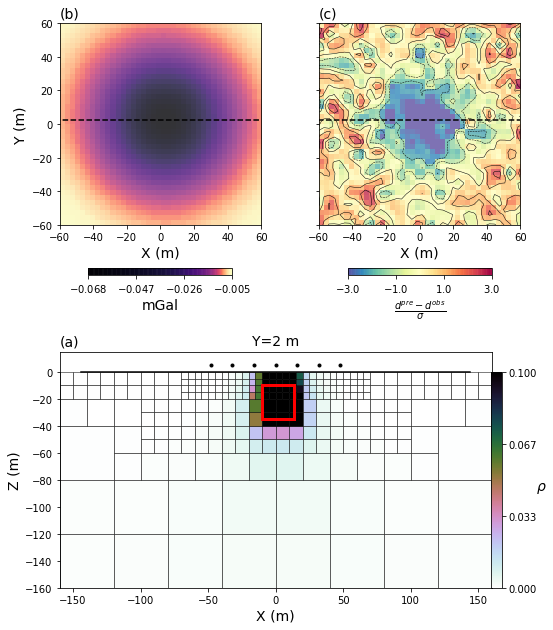

In [192]:
contours = [0.01]
xlim = 160.
midy = int(np.searchsorted(mesh.vectorCCy, 0))
fig = plt.figure(figsize=(8, 8))
ax3 = plt.axes([0., 0.5, 0.5, .5])

actvMap = Maps.InjectActiveCells(mesh, actv, np.nan)
mrec_den_l2 = invProb.model
dpred = probGrav.fields(mrec_den_l2)

# profile coordinates
a = np.r_[-xlim, mesh.vectorCCy[midy]]
b = np.r_[xlim, mesh.vectorCCy[midy]]
# PF.Magnetics.plotModelSections(mesh, mrec_sus, normal='z', ind=-3, subFact=2, scale=0.25, xlim=[-xlim, xlim], ylim=[-xlim, xlim],
#                       title="Esus Model", axs=ax3, vmin=0, vmax=vmax, contours = contours)
# ax3.xaxis.set_visible(False)
vmin, vmax = dpred.min(), dpred.max()
X, Y, d_grid, im, CS = Simulator.plotDataHillside(
                        surveyGrav.srcField.rxList[0].locs[:,0],
                        surveyGrav.srcField.rxList[0].locs[:,1], 
                        dpred , distMax=200, minCurvature=False,
                          cmap='magma', resolution=3., axs=ax3,
                        vmin=vmin, vmax=vmax,
                          clabel=False, contours=np.r_[0.01, 0.0125, 0.015, 0.02, 0.04],  
                          alpha=0.8, alphaHS=0, ve=1., azdeg=30, altdeg=30)


cbar = plt.colorbar(im, ticks=np.linspace(vmin, vmax, 4),
            format="${%.3f}$", shrink=0.5, orientation='horizontal')
cbar.set_label("mGal", rotation=0, size=14)
ax3.set_xlabel('X (m)', size=14)
ax3.set_ylabel('Y (m)', size=14)
ax3.set_aspect('equal')
# ax3.set_xlabel("")
ax3.set_title("(b)", loc='left', size=14)
# ax3.set_xticks([])
pos = ax3.get_position()
ax3.set_position([pos.x0, pos.y0, pos.height, pos.width])
ax3.plot(np.r_[a[0], b[0]], np.r_[a[1], b[1]], 'k--')


ax3 = plt.axes([0.45, 0.5, 0.5, .5])
vmin, vmax = -3,3
X, Y, d_grid, im, CS = Simulator.plotDataHillside(
                        surveyGrav.srcField.rxList[0].locs[:,0],
                        surveyGrav.srcField.rxList[0].locs[:,1], 
                        (surveyGrav.dobs-dpred)/surveyGrav.std , distMax=200, minCurvature=False,
                          cmap='Spectral_r', resolution=3., axs=ax3, 
                            vmin=vmin, vmax=vmax, equalizeHist=False,
                          clabel=False, contours=[-2,-1,0,1,2],  
                          alpha=0.8, alphaHS=0, ve=1., azdeg=30, altdeg=30)

cbar = plt.colorbar(im, ticks=np.linspace(vmin,vmax, 4),
            format="${%.1f}$", shrink=0.5, orientation='horizontal')
cbar.set_label("$\\frac{d^{pre} - d^{obs}}{\sigma}$", rotation=0, size=14)
ax3.set_xlabel('X (m)', size=14)
ax3.set_ylabel('', size=14)
ax3.set_aspect('equal')
# ax3.set_xlabel("")
ax3.set_title("(c)", loc='left', size=14)
ax3.set_yticklabels([])
pos = ax3.get_position()
ax3.set_position([pos.x0, pos.y0, pos.height, pos.width])
ax3.plot(np.r_[a[0], b[0]], np.r_[a[1], b[1]], 'k--')

# Plot the model
ax2 = plt.axes([0.05, -0.175, 0.75, .75])
vmax = 0.1
vmin = 0
# im2 = mesh.plotSlice(
#     actvMap * sus, ind=midy, normal='Y', ax=ax2,
#     pcolorOpts={"cmap":"pink_r"}, grid=True) 

im1 = mesh.plotSlice(
    actvMap * mrec_den_l2, ind=midy, normal='Y', ax=ax2, grid=True,
    pcolorOpts={"cmap":"cubehelix_r","clim":[vmin,vmax]}, clim=[vmin, vmax]) 
# cbar.set_label("$\kappa_e$", rotation=0, size=14)
ax2.set_aspect('equal')
ax2.set_xlim([-xlim, xlim])
ax2.set_ylim([-xlim, 15])
ax2.grid(False)

# plotVectorsOctree(mesh, mvec_true, 0, axs=ax2, scale=0.4, vec='w', resolution=10, normal='Y', actvMap=actvMap, zorder=4)
# for midx in locx:
ax2.add_patch(Rectangle(corners[0][::2],corners[1][0] - corners[0][0],corners[1][2] - corners[0][2], facecolor = 'none', edgecolor='r', linewidth=3))
# ax2.grid(color='w', linestyle='--', linewidth=0.5)
loc = ax2.get_position()
ax2.set_position([loc.x0+0.025, loc.y0+0.025, loc.width, loc.height])
ax2.set_xlabel('X (m)', size=14)
ax2.set_ylabel('Z (m)', size=14)
ax2.set_title("(a)", loc='left', size=14)
ax2.set_title("Y=%.0f" % mesh.vectorCCy[midy] + " m", loc='center', size=14)
Utils.PlotUtils.plotProfile(
    xyzLoc, a, b, 21, fig=fig,
    ax=ax2, coordinate_system='xProfile',
    plotStr='k.'
)
Utils.PlotUtils.plotProfile(
    topo, a, b, 21, fig=fig,
    ax=ax2, coordinate_system='xProfile',
)

pos = ax2.get_position()
cbarAxis = plt.axes([pos.x0+0.4, pos.y0, pos.height, pos.width*0.5])
cbarAxis.axis('off')
cbar = plt.colorbar(im1[0], ax = cbarAxis, ticks=np.linspace(0, vmax, 4),
            format="%.3f", orientation='vertical')
cbar.set_label("$\\rho$", rotation=0, size=14)


# ax2.axis('off')
# cbarAxis = plt.axes([pos.x0+0.5, pos.y0, pos.height, pos.width*0.5])
# cbarAxis.axis('off')
# cbar = plt.colorbar(im1[0], ax = cbarAxis, ticks=np.linspace(0, den.max(), 5),
#             format="%.1f", orientation='vertical')
# cbar.set_ticklabels(["%.2f" % ii for ii in np.linspace(0, 0.2, 5).tolist()]
# )
# cbar.set_label("$\\rho$", rotation=0, size=14)
# "cubehelix_r"

plt.savefig("Grav_Inv_5m_cells_Simple_halfCore_l1_as1_dx2.png", bbox_inches='tight', dpi=300)

# Repeat with Tikhonov style

In [199]:
reg_Tikh.norms









array([[2., 0., 0., 0.],
       [2., 0., 0., 0.],
       [2., 0., 0., 0.],
       ...,
       [2., 0., 0., 0.],
       [2., 0., 0., 0.],
       [2., 0., 0., 0.]])

In [202]:
# padding_distance = [[50, 50], [50, 50], [200, 50]]

# Create a mesh
# dx = 2.5#5#
# core_cell_size = [dx, dx, dx]
# octree_levels_padding = [1,3]
# octree_levels_obs = [20,8]#[10,4]#
# octree_levels_topo = [0,2] 

# mesh = meshutils.mesh_builder_xyz(
#     topo, core_cell_size, padding_distance=padding_distance,
#     base_mesh=None,
#     mesh_type='TREE',
# )
# # mesh.x0 = [-315, -312.5, -340]
# mesh = meshutils.refine_tree_xyz(mesh, topo, octree_levels=octree_levels_topo, octree_levels_padding=[0,0], method='surface', finalize=False)
# mesh = meshutils.refine_tree_xyz(
#     mesh, xyzLoc, 
#     octree_levels=octree_levels_obs, octree_levels_padding=octree_levels_padding, method='surface', finalize=True
# )

# actv = Utils.surface2ind_topo(mesh, topo, 'CC')

# # Create active map to go from reduce space to full
# actvMap = Maps.InjectActiveCells(mesh, actv, -100)
# nC = int(actv.sum())

# # Create reduced identity map
# idenMap = Maps.IdentityMap(nP=nC)

# Create the forward probGravlem
probGrav = PF.Gravity.GravityIntegral(mesh, rhoMap=idenMap, actInd=actv,
                                     Jpath='.\\sensGrav.zarr',
                                      verbose=False, parallelized='dask')

# Pair the surveyMag and probMaglem and compute data
surveyGrav.unpair()
surveyGrav.pair(probGrav)

# Create a regularization function, in this case l2l2
wr = probGrav.getJtJdiag(np.ones(nC))**0.5
wr = (wr/np.max(wr)) 

# Create a regularization
# reg_Tikh = Regularization.Tikhonov(mesh, indActive=actv, mapping=idenMap)
# reg_Tikh.cell_weights = wr
# reg_Tikh.alpha_s = 1./dx**2.


reg_Tikh = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap, gradientType='component')
reg_Tikh.cell_weights = wr
reg_Tikh.mref = np.zeros(nC)
reg_Tikh.norms = np.c_[2, 0, 0, 0]

for ii, objfct in enumerate(reg_Tikh.objfcts[1:]):
    objfct.cell_weights *= mesh.h_gridded[actv, ii]**reg_Tikh.norms[:, ii]
    

Pac = Utils.speye(mesh.nC)[:, actv]
indActive_Fx = (
    (mesh._aveCC2FxStencil() * actv) >= 1
)
Pafx = (
    Utils.speye(mesh.ntFx)[:, indActive_Fx]
)

reg_Tikh.regmesh._cellDiffxStencil = Pafx.T * sdiag(mesh._aveCC2FxStencil() * (1./mesh.h_gridded[:, 0])) * mesh._cellGradxStencil * Pac 


indActive_Fy = (
    (mesh._aveCC2FyStencil() * actv) >= 1
)
Pafy = (
    Utils.speye(mesh.ntFy)[:, indActive_Fy]
)

reg_Tikh.regmesh._cellDiffyStencil = Pafy.T * sdiag(mesh._aveCC2FyStencil() * (1./mesh.h_gridded[:, 1])) * mesh._cellGradyStencil * Pac 


indActive_Fz = (
    (mesh._aveCC2FzStencil() * actv) >= 1
)
Pafz = (
    Utils.speye(mesh.ntFz)[:, indActive_Fz]
)

reg_Tikh.regmesh._cellDiffzStencil = Pafz.T * sdiag(mesh._aveCC2FzStencil() * (1./mesh.h_gridded[:, 2])) * mesh._cellGradzStencil * Pac 



# Data misfit function
dmis = DataMisfit.l2_DataMisfit(surveyGrav)
dmis.W = 1./surveyGrav.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=100, lower=-1., upper=1.,
                                 maxIterLS=20, maxIterCG=20, tolCG=1e-3)
invProb = InvProblem.BaseInvProblem(dmis, reg_Tikh, opt)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e+0)

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, betaSearch=False, maxIRLSiter=20, chifact_target=2, chifact_start=2)
update_Jacobi = Directives.UpdatePreconditioner()
inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, IRLS, update_Jacobi])
# Run the inversion
m0 = np.ones(nC)*1e-4  # Starting model
mrec_den_l2 = inv.run(m0)




Dask:
n_cpu:  8
n_chunks:  8
Chunk sizes:  56 919
RAM/chunk:  0.000411712
Total RAM (x n_cpu):  0.003293696
Zarr file detected with same shape and chunksize ... re-loading
Use Simple
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
1.0 1.0
1.0 1.0
1.0 1.0
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.09e+06  5.94e+03  1.03e-06  5.94e+03    8.57e+01      0              
Start CG solve
CG solve time: 3.0389983654022217
   1  5.47e+05  3.05e+03  7.33e-04  3.45e+03    8.11e+01      0              
Start CG solve
CG solve time: 3.0269997119903564
   2  2.73e+05  2.57e+03  1.37e-03  2.94e+03    7.67e+01      0   Skip BFGS  
Start CG solve
CG solve time: 3.0080013275146484
   3  1.37e+05  2.04e

C:\Users\DominiqueFournier\Documents\GIT\GeoToolkit\GeoToolkit\Mag\Simulator.py:734: UserWarning: No contour levels were found within the data range.
  colors='k', linewidths=0.5


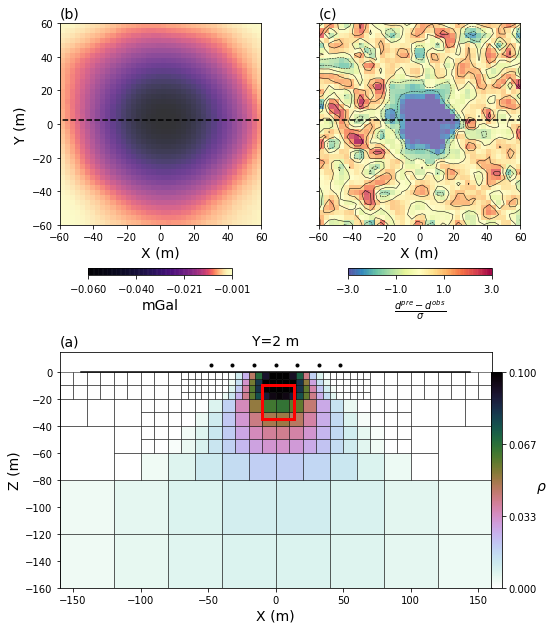

In [203]:
contours = [0.01]
xlim = 160.
midy = int(np.searchsorted(mesh.vectorCCy, 0))
fig = plt.figure(figsize=(8, 8))
ax3 = plt.axes([0., 0.5, 0.5, .5])


mrec_den_l2 = invProb.model
actvMap = Maps.InjectActiveCells(mesh, actv, np.nan)

dpred = probGrav.fields(mrec_den_l2)

# profile coordinates
a = np.r_[-xlim, mesh.vectorCCy[midy]]
b = np.r_[xlim, mesh.vectorCCy[midy]]
# PF.Magnetics.plotModelSections(mesh, mrec_sus, normal='z', ind=-3, subFact=2, scale=0.25, xlim=[-xlim, xlim], ylim=[-xlim, xlim],
#                       title="Esus Model", axs=ax3, vmin=0, vmax=vmax, contours = contours)
# ax3.xaxis.set_visible(False)
vmin, vmax = dpred.min(), dpred.max()
X, Y, d_grid, im, CS = Simulator.plotDataHillside(
                        surveyGrav.srcField.rxList[0].locs[:,0],
                        surveyGrav.srcField.rxList[0].locs[:,1], 
                        dpred , distMax=200, minCurvature=False,
                          cmap='magma', resolution=3., axs=ax3,
                        vmin=vmin, vmax=vmax,
                          clabel=False, contours=np.r_[0.01, 0.0125, 0.015, 0.02, 0.04],  
                          alpha=0.8, alphaHS=0, ve=1., azdeg=30, altdeg=30)


cbar = plt.colorbar(im, ticks=np.linspace(vmin, vmax, 4),
            format="${%.3f}$", shrink=0.5, orientation='horizontal')
cbar.set_label("mGal", rotation=0, size=14)
ax3.set_xlabel('X (m)', size=14)
ax3.set_ylabel('Y (m)', size=14)
ax3.set_aspect('equal')
# ax3.set_xlabel("")
ax3.set_title("(b)", loc='left', size=14)
# ax3.set_xticks([])
pos = ax3.get_position()
ax3.set_position([pos.x0, pos.y0, pos.height, pos.width])
ax3.plot(np.r_[a[0], b[0]], np.r_[a[1], b[1]], 'k--')


ax3 = plt.axes([0.45, 0.5, 0.5, .5])
vmin, vmax = -3,3
X, Y, d_grid, im, CS = Simulator.plotDataHillside(
                        surveyGrav.srcField.rxList[0].locs[:,0],
                        surveyGrav.srcField.rxList[0].locs[:,1], 
                        (surveyGrav.dobs-dpred)/surveyGrav.std , distMax=200, minCurvature=False,
                          cmap='Spectral_r', resolution=3., axs=ax3, 
                            vmin=vmin, vmax=vmax, equalizeHist=False,
                          clabel=False, contours=[-2,-1,0,1,2],  
                          alpha=0.8, alphaHS=0, ve=1., azdeg=30, altdeg=30)

cbar = plt.colorbar(im, ticks=np.linspace(vmin,vmax, 4),
            format="${%.1f}$", shrink=0.5, orientation='horizontal')
cbar.set_label("$\\frac{d^{pre} - d^{obs}}{\sigma}$", rotation=0, size=14)
ax3.set_xlabel('X (m)', size=14)
ax3.set_ylabel('', size=14)
ax3.set_aspect('equal')
# ax3.set_xlabel("")
ax3.set_title("(c)", loc='left', size=14)
ax3.set_yticklabels([])
pos = ax3.get_position()
ax3.set_position([pos.x0, pos.y0, pos.height, pos.width])
ax3.plot(np.r_[a[0], b[0]], np.r_[a[1], b[1]], 'k--')

# Plot the model
ax2 = plt.axes([0.05, -0.175, 0.75, .75])
vmax = 0.1
vmin = 0.00
# im2 = mesh.plotSlice(
#     actvMap * sus, ind=midy, normal='Y', ax=ax2,
#     pcolorOpts={"cmap":"pink_r"}, grid=True) 

im1 = mesh.plotSlice(
    actvMap * mrec_den_l2, ind=midy, normal='Y', ax=ax2, grid=True,
    pcolorOpts={"cmap":"cubehelix_r","clim":[vmin,vmax]}, clim=[vmin, vmax]) 
# cbar.set_label("$\kappa_e$", rotation=0, size=14)
ax2.set_aspect('equal')
ax2.set_xlim([-xlim, xlim])
ax2.set_ylim([-xlim, 15])
ax2.grid(False)

# plotVectorsOctree(mesh, mvec_true, 0, axs=ax2, scale=0.4, vec='w', resolution=10, normal='Y', actvMap=actvMap, zorder=4)
# for midx in locx:
ax2.add_patch(Rectangle(corners[0][::2],corners[1][0] - corners[0][0],corners[1][2] - corners[0][2], facecolor = 'none', edgecolor='r', linewidth=3))
# ax2.grid(color='w', linestyle='--', linewidth=0.5)
loc = ax2.get_position()
ax2.set_position([loc.x0+0.025, loc.y0+0.025, loc.width, loc.height])
ax2.set_xlabel('X (m)', size=14)
ax2.set_ylabel('Z (m)', size=14)
ax2.set_title("(a)", loc='left', size=14)
ax2.set_title("Y=%.0f" % mesh.vectorCCy[midy] + " m", loc='center', size=14)
Utils.PlotUtils.plotProfile(
    xyzLoc, a, b, 21, fig=fig,
    ax=ax2, coordinate_system='xProfile',
    plotStr='k.'
)
Utils.PlotUtils.plotProfile(
    topo, a, b, 21, fig=fig,
    ax=ax2, coordinate_system='xProfile',
)

pos = ax2.get_position()
cbarAxis = plt.axes([pos.x0+0.4, pos.y0, pos.height, pos.width*0.5])
cbarAxis.axis('off')
cbar = plt.colorbar(im1[0], ax = cbarAxis, ticks=np.linspace(0, vmax, 4),
            format="%.3f", orientation='vertical')
cbar.set_label("$\\rho$", rotation=0, size=14)


# ax2.axis('off')
# cbarAxis = plt.axes([pos.x0+0.5, pos.y0, pos.height, pos.width*0.5])
# cbarAxis.axis('off')
# cbar = plt.colorbar(im1[0], ax = cbarAxis, ticks=np.linspace(0, den.max(), 5),
#             format="%.1f", orientation='vertical')
# cbar.set_ticklabels(["%.2f" % ii for ii in np.linspace(0, 0.2, 5).tolist()]
# )
# cbar.set_label("$\\rho$", rotation=0, size=14)
# "cubehelix_r"

# plt.savefig("Grav_Inv_5m_cells_TikhonovLike_halfCore_lp1_as1_dx.png", bbox_inches='tight', dpi=300)

In [93]:
reg_Susc = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap, gradientType='component')
reg_Susc.cell_weights = wr
# reg_Susc.alpha_s = 1./dx**2.
Pac = Utils.speye(mesh.nC)[:, actv]
indActive_Fx = (
    (mesh._aveCC2FxStencil() * actv) >= 1
)
Pafx = (
    Utils.speye(mesh.ntFx)[:, indActive_Fx]
)

reg_Susc.regmesh._cellDiffxStencil = Pafx.T * sdiag(mesh._aveCC2FxStencil() * (1./mesh.h_gridded[:, 0])) * mesh._cellGradxStencil * Pac 


indActive_Fy = (
    (mesh._aveCC2FyStencil() * actv) >= 1
)
Pafy = (
    Utils.speye(mesh.ntFy)[:, indActive_Fy]
)

reg_Susc.regmesh._cellDiffyStencil = Pafy.T * sdiag(mesh._aveCC2FyStencil() * (1./mesh.h_gridded[:, 1])) * mesh._cellGradyStencil * Pac 


indActive_Fz = (
    (mesh._aveCC2FzStencil() * actv) >= 1
)
Pafz = (
    Utils.speye(mesh.ntFz)[:, indActive_Fz]
)

reg_Susc.regmesh._cellDiffzStencil = Pafz.T * sdiag(mesh._aveCC2FzStencil() * (1./mesh.h_gridded[:, 2])) * mesh._cellGradzStencil * Pac 

reg_Susc.objfcts[1](mrec_den_l2), reg_Susc.objfcts[2](mrec_den_l2)


Use Simple


(3.9049016130883134e-08, 3.763769588645206e-08)

In [92]:
reg_Susc = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap, gradientType='component')
reg_Susc.cell_weights = wr

reg_Susc.objfcts[1](mrec_den_l2), reg_Susc.objfcts[2](mrec_den_l2)

Use Simple


(7.182040893681997e-07, 7.02926529553391e-07)

In [210]:
orientation = 'xyz'

orientation.index('y')


    

        

1